<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter6_multilayer_wells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

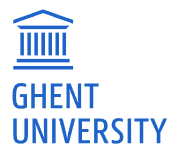<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br>
**Solutions and Theoretical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 6: Modeling Multilayer Wells**

This Jupyter notebook implements the generalized semi-analytical solution method for simulating axisymmetric (or parallel) flow to a multilayer well (or stream) developed in chapter 6 of my PhD thesis (Louwyck, 2023). It also implements the finite-difference method presented by Louwyck et al. (2012) that has been extended in chapter 6 to include multi-node wells. Both solution methods are compared with each other. The notebook also implements several well-known solutions presented in the hydrogeological literature and used to verify both newly developed solution methods.

## Solutions

Import the required packages, modules, and functions.

In [1]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import warnings
import scipy
from scipy.linalg import eig, inv, solve, LinAlgWarning, LinAlgError
from scipy.special import i0, k0, i1, k1, exp1, factorial as fact
from math import factorial, log

Check versions:

In [2]:
# print("NumPy", np.__version__)
# print("Matplotlib", matplotlib.__version__)
# print("SciPy", scipy.__version__)

### Stehfest algorithm

Function `stehfest` implements the Stehfest (1970) algorithm:

In [21]:
def stehfest(F, t, ns=12, shape_F=None):
    """
    Stehfest algorithm for numerical inversion of Laplace transforms.

    Parameters
    ----------
    F : callable
      Function that calculates the Laplace transform. It has frequency parameter `p` [1/T] as input
      and returns the Laplace-transform `F(p)`. Input parameter `p` is a one-dimensional numpy array,
      and the returned output is also a one-dimensional numpy array with the same length as `p`.
    t : array_like
      One-dimensional array with the real times `t` [T].
    ns : int, default: 12
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.
    shape_F : tuple, default: `None`
            Shape of array returned by `F`. If `None`, shape is `(nt, )` with `nt` the length of `t`.

    Returns
    -------
    f : ndarray
      One-dimensional array with the numerically inverted values `f(t)`. The length of `f` equals the length of `t`.
    """
    t = np.array(t)
    if t.ndim == 0:
        t = t[np.newaxis]
    nt = len(t)
    ns = int(ns)
    ln2t = log(2) / t
    W = stehfest_weights(ns)
    if shape_F is not None:
        f = np.zeros(shape_F + (nt, ))
    else:
        f = np.zeros(nt)
    for k in range(ns):
        p = ln2t * (k + 1)
        f += W[k] * F(p)
    return f * ln2t

def stehfest_weights(ns):
    """
    Calculate weights required for applying the Stehfest algorithm.

    Parameters
    ----------
    ns : int
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    W : ndarray
      One-dimensional array with weights, length of `W` is equal to `ns`.
    """
    fac = lambda x: float(factorial(x))
    ns2 = ns // 2
    W = np.zeros(ns)
    for j in range(1, ns + 1):
        m = min(j, ns2)
        k_0 = (j + 1) // 2
        for k in range(k_0, m + 1):
            W[j - 1] += k ** ns2 * fac(2 * k) / fac(ns2 - k) / fac(k) / fac(k - 1) / fac(j - k) / fac(2 * k - j)
        W[j - 1] *= (-1) ** (ns2 + j)
    return W

### Generalized semi-analytical solution

Class to simulate steady-state radial or parallel multilayer-multizone flow to a multilayer well or stream (Louwyck, 2023):

In [4]:
class Steady:
    """
    Class to simulate steady-state radial or parallel multilayer-multizone flow to a multilayer well or stream.

    Parameters
    ----------
    R : array_like
      Distances [L] of zone boundaries. The length of `R` is `nz+1` with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nz)` with `nl` the number of layers.
    c : array_like
      Vertical resistances [T]. The shape of `c` is `(nl+1, nz)`.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nw`, the number of wells.
    H : array_like, default: `None`
      Constant heads [L] at inner model boundary. The length of `H` is `nw`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The shape of `N` is `(nl, nz)`.
    h0 : array_like, default: `None`
       Constant heads [L]. The shape of `h0` is `(nl+2, nz)`.
       Note that only `h0[0, :]`, `h0[-1, :]`, and `h0[:, -1]` are relevant for steady-state flow.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.
    iwell : array_like, default: `None`
          Indicates which layers are connected at the inner model boundary.
          Screened layers have integers > 0.

    Attributes
    ----------
    nl : int
       Number of layers
    nz : int
       Number of zones
    nw : int
       Number of wells = max(iwell)
    has_mnw : bool
            Indicates whether or not multilayer wells or streams are defined.
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.
    eps : float, default is `1e-16`
        Integration constants lower than `eps` are set to zero.

    Methods
    -------
    h(r) :
         Calculate hydraulic head h [L] at given distances r [L].
    qh(r) :
          Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L].
    """

    def __init__(self, R, T, c, Q=None, H=None, N=None, h0=None, axi=True, iwell=None):
        self.R = np.array(R)
        self.T = np.array(T)
        self.c = np.array(c)
        self.Q = None if Q is None else np.array(Q)
        self.H = None if H is None else np.array(H)
        self.nl, self.nz = self.T.shape
        if N is None:
            self.N = np.zeros((self.nl, self.nz))
        else:
            self.N = np.array(N)
        if h0 is None:
            self.h0 = np.zeros((self.nl+2, self.nz))
        else:
            self.h0 = np.array(h0)
        self.axi = axi
        self.iwell = np.arange(1, self.nl + 1, dtype=int) if iwell is None else np.array(iwell, dtype=int)
        self.nw = self.iwell.max()  # iwell starts with 1!
        self.has_mnw = self.H is None and (self.nw < self.nl)
        self.confined = np.all(np.isinf([self.c[0, :], self.c[-1, :]]), axis=0)
        self._initialized = False
        self.eps = 1e-16
        self.no_warnings = True

    def _ini_(self):
        if not self._initialized:
            self._Ab_()
            self._eig_()
            if self.axi:
                self._IKm_axi_()
                self._XYz_axi_()
            else:
                self._IKm_par_()
                self._XYz_par_()
            self._ini_M_()
            self._alpha_beta_()
            self._initialized = True

    def _Ab_(self):
        self._A = np.zeros((self.nz, self.nl, self.nl))  # (nz, nl, nl)
        self._b = np.zeros((self.nz, self.nl))  # (nz, nl)
        for k in range(self.nz):
            Tc0 = 1 / (self.T[:, k] * self.c[:-1, k])  # (nl, )
            Tc1 = 1 / (self.T[:, k] * self.c[1:, k])  # (nl, )
            self._idx = np.diag_indices(self.nl)
            irow, icol = self._idx
            A = np.zeros((self.nl, self.nl))  # (nl, nl)
            A[irow, icol] = Tc0 + Tc1
            A[irow[:-1], icol[:-1] + 1] = -Tc1[:-1]
            A[irow[:-1] + 1, icol[:-1]] = -Tc0[1:]
            self._A[k] = A
            b = self.N[:, k] / self.T[:, k]  # (nl, )
            b[0] += Tc0[0] * self.h0[0, k]
            b[-1] += Tc1[-1] * self.h0[-1, k]
            self._b[k] = b

    def _eig_(self):
        self._d = np.zeros((self.nz, self.nl))
        self._V = np.zeros((self.nz, self.nl, self.nl))
        self._iV = np.zeros((self.nz, self.nl, self.nl))
        self._v = np.zeros((self.nz, self.nl))
        self._inz = []
        self._iz = []
        self._sd = []
        for k in range(self.nz):
            d, V = eig(self._A[k])  # (nl, ), (nl, nl)
            d = np.real(d)
            inz = np.arange(self.nl)
            if self.confined[k]:
                iz = np.argmin(np.abs(d))
                inz = np.setdiff1d(inz, iz)
            else:
                iz = []
            if len(inz) > 0:
                sd = np.sqrt(d[inz])
            else:
                sd = []
            iV = inv(V)
            self._d[k] = d
            self._V[k] = V
            self._iV[k] = iV
            self._inz.append(inz)
            self._iz.append(iz)
            self._sd.append(sd)
            self._v[k] = np.dot(iV, self._b[k])

    def _IKm_axi_(self):
        self._I1 = np.zeros((self.nz, self.nl, self.nl))
        self._K1 = np.zeros((self.nz, self.nl, self.nl))
        self._m1 = np.zeros((self.nz, self.nl))
        self._I2 = np.zeros((self.nz, self.nl, self.nl))
        self._K2 = np.zeros((self.nz, self.nl, self.nl))
        self._m2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            I1, K1 = np.zeros(self.nl), np.zeros(self.nl)
            I2, K2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                I1[iz], I2[iz] = np.log(self.R[k]), np.log(self.R[k+1])
                K1[iz], K2[iz] = 1.0, 1.0
                self._m1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 4
                self._m2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 4
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                I1[inz], I2[inz] = i0(x1), i0(x2)
                I1[np.isnan(I1)] = np.inf  # i0(inf) = inf
                I2[np.isnan(I2)] = np.inf  # i0(inf) = inf
                K1[inz], K2[inz] = k0(x1), k0(x2)
                self._m1[k, inz] = self._m2[k, inz] = self._v[k][inz] / self._d[k][inz]
            self._I1[k], self._I2[k] = np.dot(self._V[k], np.diag(I1)), np.dot(self._V[k], np.diag(I2))
            self._K1[k], self._K2[k] = np.dot(self._V[k], np.diag(K1)), np.dot(self._V[k], np.diag(K2))
            self._m1[k], self._m2[k] = np.dot(self._V[k], self._m1[k]), np.dot(self._V[k], self._m2[k])

    def _IKm_par_(self):
        self._I1 = np.zeros((self.nz, self.nl, self.nl))
        self._K1 = np.zeros((self.nz, self.nl, self.nl))
        self._m1 = np.zeros((self.nz, self.nl))
        self._I2 = np.zeros((self.nz, self.nl, self.nl))
        self._K2 = np.zeros((self.nz, self.nl, self.nl))
        self._m2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            I1, K1 = np.zeros(self.nl), np.zeros(self.nl)
            I2, K2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                I1[iz], I2[iz] = self.R[k], self.R[k+1]
                K1[iz], K2[iz] = 1.0, 1.0
                self._m1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 2
                self._m2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 2
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                I1[inz], I2[inz] = np.exp(x1), np.exp(x2)
                K1[inz], K2[inz] = np.exp(-x1), np.exp(-x2)
                self._m1[k, inz] = self._m2[k, inz] = self._v[k][inz] / self._d[k][inz]
            self._I1[k], self._I2[k] = np.dot(self._V[k], np.diag(I1)), np.dot(self._V[k], np.diag(I2))
            self._K1[k], self._K2[k] = np.dot(self._V[k], np.diag(K1)), np.dot(self._V[k], np.diag(K2))
            self._m1[k], self._m2[k] = np.dot(self._V[k], self._m1[k]), np.dot(self._V[k], self._m2[k])

    def _XYz_axi_(self):
        self._X1 = np.zeros((self.nz, self.nl, self.nl))
        self._Y1 = np.zeros((self.nz, self.nl, self.nl))
        self._z1 = np.zeros((self.nz, self.nl))
        self._X2 = np.zeros((self.nz, self.nl, self.nl))
        self._Y2 = np.zeros((self.nz, self.nl, self.nl))
        self._z2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            TV = np.dot(np.diag(2 * np.pi * self.T[:, k]), self._V[k])
            X1, X2 = np.zeros(self.nl), np.zeros(self.nl)
            Y1, Y2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                X1[iz], X2[iz] = 1.0, 1.0
                self._z1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 2
                self._z2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 2
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                X1[inz], X2[inz] = x1 * i1(x1), x2 * i1(x2)
                X1[np.isnan(X1)] = np.inf  # inf*i1(inf) = inf
                X2[np.isnan(X2)] = np.inf  # inf*i1(inf) = inf
                Y1[inz], Y2[inz] = -x1 * k1(x1), -x2 * k1(x2)
                b1, b2 = np.isnan(Y1), np.isnan(Y2)
                if np.any(b1):
                    if np.all(x1[b1[inz]] < 1):
                        Y1[b1] = -1.0  # 0*k1(0) = 1
                    else:
                        Y1[b1] = 0.0  # inf*k1(inf) = 0
                if np.any(b2):
                    if np.all(x2[b2[inz]] < 1):
                        Y2[b2] = -1.0  # 0*k1(0) = 1
                    else:
                        Y2[b2] = 0.0  # inf*k1(inf) = 0
            self._X1[k], self._X2[k] = np.dot(TV, np.diag(X1)), np.dot(TV, np.diag(X2))
            self._Y1[k], self._Y2[k] = np.dot(TV, np.diag(Y1)), np.dot(TV, np.diag(Y2))
            self._z1[k], self._z2[k] = np.dot(TV, self._z1[k]), np.dot(TV, self._z2[k])

    def _XYz_par_(self):
        self._X1 = np.zeros((self.nz, self.nl, self.nl))
        self._Y1 = np.zeros((self.nz, self.nl, self.nl))
        self._z1 = np.zeros((self.nz, self.nl))
        self._X2 = np.zeros((self.nz, self.nl, self.nl))
        self._Y2 = np.zeros((self.nz, self.nl, self.nl))
        self._z2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            TV = np.dot(np.diag(self.T[:, k]), self._V[k])
            X1, X2 = np.zeros(self.nl), np.zeros(self.nl)
            Y1, Y2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                X1[iz], X2[iz] = 1.0, 1.0
                self._z1[k, iz] = -self._v[k][iz] * self.R[k]
                self._z2[k, iz] = -self._v[k][iz] * self.R[k+1]
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                X1[inz], X2[inz] = self._sd[k] * np.exp(x1), self._sd[k] * np.exp(x2)
                Y1[inz], Y2[inz] = -self._sd[k] * np.exp(-x1), -self._sd[k] * np.exp(-x2)
            self._X1[k], self._X2[k] = np.dot(TV, np.diag(X1)), np.dot(TV, np.diag(X2))
            self._Y1[k], self._Y2[k] = np.dot(TV, np.diag(Y1)), np.dot(TV, np.diag(Y2))
            self._z1[k], self._z2[k] = np.dot(TV, self._z1[k]), np.dot(TV, self._z2[k])

    def _ini_M_(self):
        n = 2 * self.nl * self.nz
        if self.has_mnw:
            n += self.nw
            ns = np.sum(self.iwell > 0)
            E = np.zeros((self.nl, ns), dtype=int)
            U = np.zeros((ns, self.nw), dtype=int)
            N = np.zeros((self.nl - ns, self.nl), dtype=int)
            i_no_screen, i_screen = 0, 0
            for i in range(self.nl):
                if self.iwell[i] == 0:
                    N[i_no_screen, i] = 1
                    i_no_screen += 1
                else:
                    E[i, i_screen] = 1
                    U[i_screen, self.iwell[i] - 1] = 1
                    i_screen += 1
            ET = E.T
            self._EUT = np.dot(U.T, ET)
        M = np.zeros((n, n))
        rhs = np.zeros(n)
        if self.has_mnw:
            i = np.arange(0, 2) * self.nl + self.nw
            j = np.arange(-2, 3) * self.nl + self.nw
            M[:self.nw, j[2]:j[3]] = -np.dot(self._EUT, self._Y1[0])
            M[:self.nw, j[3]:j[4]] = -np.dot(self._EUT, self._X1[0])
            rhs[:self.nw] = np.dot(self._EUT, self._z1[0]) + self.Q
            k = i[0] + ns
            M[i[0]:k, :self.nw] = U
            M[i[0]:k, j[2]:j[3]] = -np.dot(ET, self._K1[0])
            M[i[0]:k, j[3]:j[4]] = -np.dot(ET, self._I1[0])
            rhs[i[0]:k] = np.dot(ET, self._m1[0])
            M[k:i[1], j[2]:j[3]] = -np.dot(N, self._Y1[0])
            M[k:i[1], j[3]:j[4]] = -np.dot(N, self._X1[0])
            rhs[k:i[1]] = np.dot(N, self._z1[0])
        else:
            i = np.arange(0, 2) * self.nl
            j = np.arange(-2, 3) * self.nl
            if self.Q is not None:
                M[i[0]:i[1], j[2]:j[3]] = -self._Y1[0]
                M[i[0]:i[1], j[3]:j[4]] = -self._X1[0]
                rhs[i[0]:i[1]] = self._z1[0] + self.Q
            else:
                M[i[0]:i[1], j[2]:j[3]] = -self._K1[0]
                M[i[0]:i[1], j[3]:j[4]] = -self._I1[0]
                rhs[i[0]:i[1]] = self._m1[0] - self.H
        self._M, self._rhs = M, rhs
        self.__idx = i, j

    def _alpha_beta_(self):
        # apply scipy solve function to find alpha and beta
        self._alpha = np.zeros((self.nz, self.nl))
        self._beta = np.zeros((self.nz, self.nl))
        # k = 0
        i, j = self.__idx
        M, rhs = self._M, self._rhs
        # 0 < k < nz-1
        for k in range(1, self.nz):
            i += self.nl
            j += 2 * self.nl
            M[i[0]:i[1], j[0]:j[1]] = self._K2[k-1]
            M[i[0]:i[1], j[1]:j[2]] = self._I2[k-1]
            M[i[0]:i[1], j[2]:j[3]] = -self._K1[k]
            M[i[0]:i[1], j[3]:j[4]] = -self._I1[k]
            rhs[i[0]:i[1]] = self._m1[k] - self._m2[k-1]
            i += self.nl
            M[i[0]:i[1], j[0]:j[1]] = self._Y2[k-1]
            M[i[0]:i[1], j[1]:j[2]] = self._X2[k-1]
            M[i[0]:i[1], j[2]:j[3]] = -self._Y1[k]
            M[i[0]:i[1], j[3]:j[4]] = -self._X1[k]
            rhs[i[0]:i[1]] = self._z1[k] - self._z2[k-1]
        # k = nz - 1
        k = self.nz - 1
        i += self.nl
        M[i[0]:i[1], j[2]:j[3]] = self._K2[k]
        M[i[0]:i[1], j[3]:j[4]] = self._I2[k]
        rhs[i[0]:i[1]] = self.h0[1:-1, k] - self._m2[k]
        self._M, self._rhs = M.copy(), rhs.copy()
        # solve system
        self._M2, self._rhs2, self._until = self.__check_M__(M.copy(), rhs.copy())
        ab = np.zeros(len(rhs))
        try:
            ab[:self._until] = solve(self._M2, self._rhs2, check_finite=False)
        except LinAlgError:  # If M is singular, then probably all constants are zero
            ab[:self._until] = np.zeros(self._until)
        # assign alpha and beta (and H)
        i = np.arange(0, 2) * self.nl
        if self.has_mnw:
            i += self.nw
            self._H = ab[:self.nw]
        for k in range(self.nz):
            self._beta[k] = ab[i[0]:i[1]]
            i += self.nl
            self._alpha[k] = ab[i[0]:i[1]]
            i += self.nl
        self._alpha[(np.abs(self._alpha) < self.eps) | np.isnan(self._alpha)] = 0.0
        self._beta[(np.abs(self._beta) < self.eps) | np.isnan(self._beta)] = 0.0

    def __check_M__(self, M, rhs):
        # check inf
        if self.has_mnw:
            n = self.nw + self.nl
            b = np.isinf(M[n:, n:])
        else:
            b = np.isinf(M)
        if np.any(b):
            irow, icol = np.where(b)
            until = np.min([np.min(irow), np.min(icol)])
            if self.has_mnw:
                until += n
                return M[:until, :until], rhs[:until], until
            else:
                return M[:until, :until], rhs[:until], until
        else:
            return M, rhs, None

    def h(self, r):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            r = np.array(r)
            nr = len(r)
            h = np.zeros((self.nl, nr))
            for j in range(nr):
                # if self.has_mnw and (r[j] <= self.R[0]):
                #     h[:, j] = np.dot(self._EUT.T, self._H)
                # else:
                k = np.where((self.R[:-1] <= r[j]) & (r[j] <= self.R[1:]))[0][0]
                I, K, m = np.zeros(self.nl), np.zeros(self.nl), np.zeros(self.nl)
                if self.confined[k]:
                    iz = self._iz[k]
                    if self.axi:
                        I[iz], K[iz], m[iz] = np.log(r[j]), 1.0, -self._v[k][iz] * r[j]**2 / 4
                    else:
                        I[iz], K[iz], m[iz] = r[j], 1.0, -self._v[k][iz] * r[j]**2 / 2
                if len(self._inz[k]) > 0:
                    inz = self._inz[k]
                    x = r[j] * self._sd[k]
                    inz = self._inz[k]
                    if self.axi:
                        I[inz], K[inz], m[inz] = i0(x), k0(x), self._v[k][inz] / self._d[k][inz]
                    else:
                        I[inz], K[inz], m[inz] = np.exp(x), np.exp(-x), self._v[k][inz] / self._d[k][inz]
                Ia = I * self._alpha[k]
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I0 = Inf
                g = Ia + K * self._beta[k] + m
                h[:, j] = np.dot(self._V[k], g)
            return h

    def qr(self, r):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            r = np.array(r)
            nr = len(r)
            qr = np.zeros((self.nl, nr))
            for j in range(nr):
                k = np.where((self.R[:-1] <= r[j]) & (r[j] <= self.R[1:]))[0][0]
                I, K, m = np.zeros(self.nl), np.zeros(self.nl), np.zeros(self.nl)
                if self.confined[k]:
                    iz = self._iz[k]
                    if self.axi:
                        I[iz], m[iz] = 1.0, -self._v[k][iz] * r[j]**2 / 2
                    else:
                        I[iz], m[iz] = 1.0, -self._v[k][iz] * r[j]
                if len(self._inz[k]) > 0:
                    inz = self._inz[k]
                    x = r[j] * self._sd[k]
                    inz = self._inz[k]
                    if self.axi:
                        I[inz], K[inz] = x * i1(x), -x * k1(x)
                        K[np.isnan(K)] = 1.0  # r -> 0: x_in * k1(x_in) = 1
                    else:
                        I[inz], K[inz] = self._sd[k] * np.exp(x), -self._sd[k] * np.exp(-x)
                Ia = I * self._alpha[k]
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I1 = Inf
                dg = Ia + K * self._beta[k] + m
                TV = np.dot(np.diag(2 * np.pi * self.T[:, k]), self._V[k])
                qr[:, j] = np.dot(TV, dg)
            return qr

Class to simulate transient-state radial or parallel multilayer-multizone flow to a multilayer well or stream (Louwyck, 2023):

In [5]:
class Transient:
    """
    Class to simulate transient-state radial or parallel multilayer-multizone flow to a multilayer well or stream.
    The Stehfest algorithm is applied to numerically invert the Laplace transform.

    Parameters
    ----------
    R : array_like
      Distances [L] of zone boundaries. The length of `R` is `nz+1` with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nz)` with `nl` the number of layers.
    S : array_like
      Storativities [-]. The shape of `S` is `(nl, nz)`.
    c : array_like
      Vertical resistances [T]. The shape of `c` is `(nl+1, nz)`.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nw`, the number of wells.
    H : array_like, default: `None`
      Constant heads [L] at inner model boundary. The length of `H` is `nw`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The shape of `N` is `(nl, nz)`.
    h0 : array_like, default: `None`
       Initial heads [L]. The shape of `h0` is `(nl+2, nz)`.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.
    iwell : array_like, default: `None`
          Indicates which layers are connected at the inner model boundary.
          Screened layers have integers > 0. If `None`, then no layers are connected.
    rc : array_like, default: `None`
       Radius [L] of the casing of the wells. The length of `rc` is `nw`.
       If `None`, then `rc = R[0]`.
    H0 : array_like, default: `None`
       The initial head [L] in the wells. The length of `H0` is `nw`.
       If `None`, then `H0 = 0.0`.
    ns : int, default: `12`
       Number of Stehfest parameters

    Attributes
    ----------
    nl : int
       Number of layers
    nz : int
       Number of zones
    nw : int
       Number of wells = max(iwell)
    has_mnw : bool
            Indicates whether or not multilayer wells or streams are defined.
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.
    eps : float, default is `1e-16`
        Integration constants lower than `eps` are set to zero.

    Methods
    -------
    h(r, t) :
            Calculate hydraulic head h [L] at given distances r [L] and times [T].
    qh(r, t) :
             Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L] and times [T].
    """

    def __init__(self, R, T, S, c, Q=None, H=None, N=None, h0=None, axi=True, iwell=None, rc=None, H0=None, ns=12):
        self.R = np.array(R)
        self.T = np.array(T)
        self.S = np.array(S)
        self.c = np.array(c)
        self.Q = None if Q is None else np.array(Q)
        self.H = None if H is None else np.array(H)
        self.nl, self.nz = self.T.shape
        if N is None:
            self.N = np.zeros((self.nl, self.nz))
        else:
            self.N = np.array(N)
        if h0 is None:
            self.h0 = np.zeros((self.nl+2, self.nz))
        else:
            self.h0 = np.array(h0)
        self.confined = np.all(np.isinf([self.c[0, :], self.c[-1, :]]), axis=0)
        self.axi = axi
        self.iwell = np.arange(1, self.nl + 1, dtype=int) if iwell is None else np.array(iwell, dtype=int)
        self.nw = self.iwell.max()
        self.rc = self.R[0] * np.ones(self.nw) if rc is None else np.array(rc)
        self.has_mnw = self.H is None and ((self.nw < self.nl) or np.any(self.rc > 0))
        self.H0 = np.zeros(self.nw) if H0 is None else np.array(H0)
        self.ns = int(ns)
        self._W = stehfest_weights(self.ns)
        self.eps = 1e-16
        self.no_warnings = True

    def h(self, r, t):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            h = np.zeros((self.nl, len(r), len(t)))
            for i in range(len(t)):
                ln2t = np.log(2) / t[i]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    if self.Q is not None:
                        m = Steady(self.R, self.T, self.c, Q=self.Q/p, N=self.N/p, h0=self.h0/p, axi=self.axi, iwell=self.iwell)
                    elif self.H is not None:
                        m = Steady(self.R, self.T, self.c, H=self.H/p, N=self.N/p, h0=self.h0/p, axi=self.axi, iwell=self.iwell)
                    else:
                        m = Steady(self.R, self.T, self.c, Q=np.zeros(self.nw), N=self.N/p, h0=self.h0/p, axi=self.axi, iwell=self.iwell)
                    self._steady = m
                    m.eps = self.eps
                    m.no_warnings = self.no_warnings
                    m.confined = np.zeros(self.nz, dtype=bool)
                    m._Ab_()
                    for k in range(m.nz):
                        ST = self.S[:, k] / self.T[:, k]
                        m._A[k][m._idx] += ST * p
                        m._b[k] += ST * self.h0[1:-1, k]
                    m._eig_()
                    if self.axi:
                        m._IKm_axi_()
                        m._XYz_axi_()
                    else:
                        m._IKm_par_()
                        m._XYz_par_()
                    m.has_mnw = self.has_mnw
                    m._ini_M_()
                    if self.has_mnw:
                        rc = np.pi * self.rc**2 if self.axi else self.rc
                        m._M[:self.nw, :self.nw] = np.diag(rc * p)
                        m._rhs[:self.nw] += (rc * self.H0)
                    m._alpha_beta_()
                    m._initialized = True
                    h[:, :, i] += self._W[j] * m.h(r)
                h[:, :, i] *= ln2t
            return h

    def qr(self, r, t):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            qr = np.zeros((self.nl, len(r), len(t)))
            for i in range(len(t)):
                ln2t = np.log(2) / t[i]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    if self.Q is not None:
                        m = Steady(self.R, self.T, self.c, Q=self.Q/p, N=self.N/p, h0=self.h0/p, axi=self.axi, iwell=self.iwell)
                    elif self.H is not None:
                        m = Steady(self.R, self.T, self.c, H=self.H/p, N=self.N/p, h0=self.h0/p, axi=self.axi, iwell=self.iwell)
                    else:
                        m = Steady(self.R, self.T, self.c, Q=np.zeros(self.nw), N=self.N/p, h0=self.h0/p, axi=self.axi, iwell=self.iwell)
                    self._steady = m
                    m.eps = self.eps
                    m.no_warnings = self.no_warnings
                    m.confined = np.zeros(self.nz, dtype=bool)
                    m._Ab_()
                    for k in range(m.nz):
                        ST = self.S[:, k] / self.T[:, k]
                        m._A[k][m._idx] += ST * p
                        m._b[k] += ST * self.h0[1:-1, k]
                    m._eig_()
                    if self.axi:
                        m._IKm_axi_()
                        m._XYz_axi_()
                    else:
                        m._IKm_par_()
                        m._XYz_par_()
                    m.has_mnw = self.has_mnw
                    m._ini_M_()
                    if self.has_mnw:
                        rc = np.pi * self.rc**2 if self.axi else self.rc
                        m._M[:self.nw, :self.nw] = np.diag(rc * p)
                        m._rhs[:self.nw] += (rc * self.H0)
                    m._alpha_beta_()
                    m._initialized = True
                    qr[:, :, i] += self._W[j] * m.qr(r)
                qr[:, :, i] *= ln2t
            return qr

### Finite-difference solution

Class to numerically simulate two-dimensional radial or parallel flow (Louwyck, 2023):

In [6]:
class Numerical:
    """
    Class to simulate radial or parallel flow by applying the finite-difference method.
    Connecting cells is possible.

    Parameters
    ----------
    rb : array_like
       Distances [L] of cell boundaries. The length of `rb` is `nr+1` with `nr` the number of distances.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nr)` with `nl` the number of layers.
    c : array_like, default: `None`
      Vertical resistances [T]. The shape of `c` is `(nl-1, nr)`.
    t : array_like, default: `None`
      Simulation times [T]. The length of `t` is `nt`.
    S : array_like, default: `None`
      Storativities [-]. The shape of `S` is `(nl, nr)`.
    Q : array_like, default: `None`
      Discharges [L³/T] . The shape of `Q` is `(nl, nr)`.
    h0 : array_like, default: `None`
       Initial or constant heads [L]. The shape of `h0` is `(nl, nr)`.
    constant : array_like, default: `None`
             Boolean matrix indicating for each cell whether it has a constant head (`True`) or not (`False`).
             The shape of `constant` is `(nl, nr)`. If `None`, then there are no constant-head cells
    connected : array_like, default: `None`
              Integer matrix indicating which cells are connected. If `None`, then there are no connected cells.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Attributes
    ----------
    nl : int (read-only)
       Number of layers
    nr : int (read-only)
       Number of distances (columns)
    steady : bool (read-only)
           If `True`, the simulation is steady-state, otherwise it is transient-state.
    is_connected : ndarray
                 Boolean matrix indicating which cells are connected.
    r : array (read-only)
      Distances [L] at which the heads are simulated. The length of `r` is `nr`.
    h: array (read-only)
     Simulated heads [L] in each layer at distances `r` and times `t`. The shape of `h` is `(nl, nr, nt)`.
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.

    Methods
    -------
    solve() :
            Simulate the model by solving the system of finite-difference equations.
    """

    def __init__(self, rb, T, c=None, t=None, S=None, Q=None, h0=None, constant=None, connected=None, axi=True):
        self.rb = np.array(rb, dtype=float)
        self.T = np.array(T, dtype=float)
        self.nl, self.nr = self.T.shape
        self.c = None if c is None else np.array(c, dtype=float)
        self.steady = t is None
        if self.steady:
            self.t, self.S, self.nt = None, None, 0
        else:
            self.t = np.array(t, dtype=float)
            self.S = np.array(S, dtype=float)
            self.nt = len(t)
        self.Q = np.zeros(self.T.shape) if Q is None else np.array(Q, dtype=float)
        self.h0 = np.zeros(self.T.shape) if h0 is None else np.array(h0, dtype=float)
        self.constant = np.zeros(self.T.shape, dtype=bool) if constant is None else np.array(constant, dtype=bool)
        self.connected = None if connected is None else np.array(connected, dtype=int)
        self.axi = axi
        self.no_warnings = True
        if self.axi:
            rb2 = self.rb ** 2
            self._hs = np.pi * (rb2[1:] - rb2[:-1])
        else:
            self._hs = self.rb[1:] - self.rb[:-1]

    @property
    def r(self):
        if self.axi:
            return np.sqrt(self.rb[:-1] * self.rb[1:])
        else:
            return (self.rb[:-1] + self.rb[1:]) / 2

    def _qhc(self):
        qhc = np.zeros((self.nl, self.nr + 1))
        if self.axi:
            X = np.dot(1 / self.T, np.diag(np.log(self.rb[1:] / self.rb[:-1])))
            qhc[:, 1:-1] = 4.0 * np.pi / (X[:, 1:] + X[:, :-1])
        else:
            X = np.dot(1 / self.T, np.diag(self._hs))
            qhc[:, 1:-1] = 2.0  / (X[:, 1:] + X[:, :-1])
        return qhc

    def _qvc(self):
        qvc = np.zeros((self.nl + 1, self.nr))
        if self.nl > 1:
            qvc[1:-1, :] = np.dot(1 / self.c, np.diag(self._hs))
        return qvc

    def _qsc(self):
        return np.dot(self.S, np.diag(self._hs))

    def _initialize(self):
        nr = self.nr
        self._n = nr * self.nl
        irow, icol = np.diag_indices(self._n)
        self._A, self._b = None, None
        self._b0, self._A0 = -self.Q.flatten(), np.zeros((self._n, self._n))
        qhc, qvc = self._qhc(), self._qvc()
        self._A0[irow[:-1]+1, icol[:-1]] = self._A0[irow[:-1], icol[:-1]+1] = qhc[:, 1:].flatten()[:-1]
        self._A0[irow[:-nr]+nr, icol[:-nr]] = self._A0[irow[:-nr], icol[:-nr]+nr] = qvc[1:, :].flatten()[:-nr]
        self._A0[irow, icol] = -(qhc[:, :-1] + qhc[:, 1:] + qvc[:-1, :] + qvc[1:, :]).flatten()
        if np.any(self.constant):
            cst, h0 = self.constant.flatten(), self.h0.flatten()
            self._b0 -= np.dot(self._A0[:, cst], h0[cst])
        if not self.steady:
            self._dS, self._dS0 = None, self._qsc().flatten()
            self._dS0[self.constant.flatten()] = 0.0
        if self.connected is None:
            self.is_connected = np.zeros((self.nl, nr), dtype=bool)
        else:
            self.is_connected = self.connected.astype(bool)
            self._connected_ids = []
            for i in range(1, np.max(self.connected) + 1):
                row, col = (self.connected == i).nonzero()
                row0, col0 = row[0], col[0]
                row, col = row[1:], col[1:]
                first, remaining = row0 * self.nr + col0, row * self.nr + col
                self.is_connected[row0, col0] = False
                self._connected_ids.append((first, remaining))
            for first, remaining in self._connected_ids:
                self._b0[first] += self._b0[remaining].sum()
                self._A0[first, :] += self._A0[remaining, :].sum(axis=0)
                self._A0[:, first] += self._A0[:, remaining].sum(axis=1)
                if not self.steady:
                    self._dS0[first] += self._dS0[remaining].sum()
        self._variable = ~(self.constant | self.is_connected).flatten()
        self._b0 = self._b0[self._variable]
        self._A0 = self._A0[self._variable, :][:, self._variable]
        if not self.steady:
            self._dS0 = self._dS0[self._variable]

    def solve(self):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._initialize()
            if self.steady:
                shape = (self.nl, self.nr)
                self.h = self.h0.flatten()[:, np.newaxis]
                self.h[self._variable, 0] = solve(self._A0, self._b0)
            else:
                shape = (self.nl, self.nr, self.nt)
                idx = np.diag_indices_from(self._A0)
                self.h = np.tile(self.h0.flatten()[:, np.newaxis], (1, self.nt))
                for k in range(self.nt - 1):
                    self._dS = self._dS0 / (self.t[k+1] - self.t[k])
                    self._b = self._b0 - self._dS * self.h[self._variable, k]
                    self._A = self._A0.copy()
                    self._A[idx] -= self._dS
                    self.h[self._variable, k + 1] = solve(self._A, self._b)
            if self.connected is not None:
                for first, remaining in self._connected_ids:
                    self.h[remaining, :] = self.h[first, :]
            self.h = np.reshape(self.h, shape)

Helper functions to easily convert semi-analytical model into finite-difference model:

In [7]:
def Steady2Numerical(model, n=50, dr=1e-4, fg=None, R_inf=1e6):
    """
    Function to convert semi-analytical Steady model into Numerical model.

    Parameters
    ----------
    model : Steady object
          Semi-analytical steady-state model.
    n : int, default: 50
      Number of nodes in each zone.
    dr : float, default: 1e-4
       Relative distance [L] of first node.
    fg : tuple
       if axi: fg = (np.logspace, np.log10)
       if not axi, fg = (np.linspace, lambda r: r)
    R_inf : float, default: 1e6
          Distance [L] of outer boundary in numerical model.

    Returns
    -------
    num : Numerical object
        Corresponding finite-difference model.
    """
    R = model.R.copy()
    if np.isinf(R[-1]): R[-1] = R_inf
    rb = [model.R[0]] if R[0] > 0 else [dr]
    if fg is not None:
        f, g = fg
    elif model.axi:
        f, g = np.logspace, np.log10
    else:
        f, g = np.linspace, lambda r: r
    for k in range(model.nz):
        rb = np.hstack((rb, R[k] + f(g(dr), g(R[k+1] - R[k] - dr), n-1), R[k+1]))
    nr = len(rb) - 1
    if model.axi:
        rb2 = rb ** 2
        hs = np.pi * (rb2[1:] - rb2[:-1])
    else:
        hs = rb[1:] - rb[:-1]
    T = np.zeros((model.nl + 2, nr))
    c = np.zeros((model.nl + 1, nr))
    h0 = np.zeros((model.nl + 2, nr))
    constant = np.zeros((model.nl + 2, nr), dtype=bool)
    constant[:, -1] = True
    constant[0, :] = True
    constant[-1, :] = True
    Q = np.zeros((model.nl + 2, nr))
    for k in range(model.nz):
        i = np.arange(n) + k * n
        T[1:-1, i] = model.T[:, [k]]
        c[:, i] = model.c[:, [k]]
        h0[:, i] = model.h0[:, [k]]
        Q[1:-1, i] = np.outer(model.N[:, k], hs[i])
    if model.Q is not None:
        for i in range(len(model.Q)):
            Q[np.where(model.iwell == i+1)[0][0]+1, 0] += model.Q[i]
    if model.H is not None:
        h0[1:-1, 0] = model.H
        constant[1:-1, 0] = True
    if model.nw < model.nl:
        connected = np.zeros((model.nl + 2, nr), dtype=int)
        connected[1:-1, 0] = model.iwell
    else:
        connected=None
    if np.all(np.isinf(model.c[0, :])):
        T = T[1:, :]
        c = c[1:, :]
        h0 = h0[1:, :]
        constant = constant[1:, :]
        Q = Q[1:, :]
        if model.nw < model.nl: connected = connected[1:, :]
    if np.all(np.isinf(model.c[-1, :])):
        T = T[:-1, :]
        c = c[:-1, :]
        h0 = h0[:-1, :]
        constant = constant[:-1, :]
        Q = Q[:-1, :]
        if model.nw < model.nl: connected = connected[:-1, :]
    return Numerical(rb=rb, T=T, c=c, Q=Q, h0=h0, constant=constant, connected=connected, axi=model.axi)

In [8]:
def Transient2Numerical(model, t, n=50, dr=1e-4, fg=None, R_inf=1e6):
    """
    Function to convert semi-analytical Transient model into Numerical model.

    Parameters
    ----------
    model : Transient object
          Semi-analytical transient-state model.
    t : array_like
      Simulation times [L] for finite-difference model.
    n : int, default: 50
      Number of nodes in each zone.
    dr : float, default: 1e-4
       Relative distance [L] of first node.
    fg : tuple
       if axi: fg = (np.logspace, np.log10)
       if not axi, fg = (np.linspace, lambda r: r)
    R_inf : float, default: 1e6
          Distance [L] of outer boundary in numerical model.

    Returns
    -------
    num : Numerical object
        Corresponding finite-difference model.
    """
    num = Steady2Numerical(model, n=n, dr=dr, fg=fg, R_inf=R_inf)
    num.t = t
    num.nt = len(t)
    num.steady = False
    S = np.zeros((model.nl + 2, num.nr))
    for k in range(model.nz):
        i = np.arange(n) + k * n
        S[1:-1, i] = model.S[:, [k]]
    if np.any(model.rc > 0):
        if model.H is None: H0 = np.zeros(model.nl + 2)
        for i in range(len(model.rc)):
            j = np.where(model.iwell == i + 1)[0][0] + 1
            if model.axi:
                S[j, 0] = np.pi * model.rc[i]**2 / num._hs[0]
            else:
                S[j, 0] = model.rc[i] / num._hs[0]
            if model.H is None: H0[j] = model.H0[i]
    if np.all(np.isinf(model.c[0, :])):
        S = S[1:, :]
        if np.any(model.rc > 0) and model.H is None: H0 = H0[1:]
    if np.all(np.isinf(model.c[-1, :])):
        S = S[:-1, :]
        if np.any(model.rc > 0) and model.H is None: H0 = H0[:-1]
    num.S = S
    if np.any(model.rc > 0) and model.H is None:
        num.h0[:, 0] = H0
    return num

### Sokol

Function `sokol` implements the steady-state solution for a multi-aquifer well without cross-flow. The no-pumping solution is given by Sokol (1963), the pumping case by Neville & Tonkin (2004). The generalized solution for both radial and parallel flow at any distance is developed in Section 6.5.1 (Louwyck, 2023).

In [9]:
def sokol(r, rw, R, T, Q, h0=None, axi=True):
    '''
    Simulate steady flow to a multi-aquifer well without cross-flow.

    Parameters
    ----------
    r : array_like
      Radial or horizontal distances [L]
    rw : float
       Well-radius [L]
    R : int, default: 50
      Distance [L] of outer model boundary.
    T : array_like
      Transmissivities [L²/T]. Length of `T` is `nl`, the number of layers.
    Q : float
      Pumping rate [L³/T]
    h0 : array_like, default: `None`
       Constant heads [L] at outer model boundary. Length of `h0` is `nl`.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Returns
    -------
    h : ndarray
      Heads [L] in each layer at distances `r`.
      The shape of `h` is `(nl, nr)` with `nl` the number of layers and `nr` the length of `r`.
    '''
    r, T = np.array(r), np.array(T)
    h0 = np.zeros((len(T), )) if h0 is None else np.array(h0)
    if axi:
        Q = Q / 2 / np.pi  # Q < 0 is pumping
        rw, r, R = np.log(rw), np.log(r), np.log(R)
    H = (Q * (R - rw) + np.inner(T, h0)) / T.sum()
    h0 = h0[:, np.newaxis]
    return h0 + (H - h0) / (rw - R) * (r - R)

### Papadopulos

Function `papadopulos` implements the transient-state solution for a pumping well that is open to two aquifers without cross-flow (Papadopulos, 1966).

In [10]:
def papadopulos(r, t, rw, T, S, Q, h0=None, t0=0.0, ns=12):
    '''
    Simulate transient flow to a two-aquifer well without cross-flow.

    Parameters
    ----------
    r : array_like
      Radial or horizontal distances [L]
    t : array_like
      Simulation times [T]
    rw : float
       Well-radius [L]
    T : array_like
      Transmissivities [L²/T]. Length of `T` is `2`, the number of layers.
    S : array_like
      Storativities [-]. Length of `S` is `2`, the number of layers.
    Q : float
      Pumping rate [L³/T]
    h0 : array_like, default: `None`
       Initial heads [L]. Length of `h0` is `2`, the number of layers.
    t0 : float, default: `0.0`
       Time [T] at which the pumping starts.
    ns : int, default: `12`
       Number of Stehfest parameters

    Returns
    -------
    h : ndarray
      Heads [L] in each layer at distances `r` and times `t`.
      The shape of `h` is `(2, nr, nt)` with `nr` the length of `r` and `nt` the length of `t`.
    '''
    r, t = np.array(r), np.array(t)
    nr, nt = len(r), len(t)
    T, S = np.array(T), np.array(S)
    nu = T / S
    if h0 is None:
        h0 = np.array([0.0, 0.0])
    dh0 = h0[1] - h0[0]
    L1, L2 = lambda p: np.sqrt(p / nu[0]), lambda p: np.sqrt(p / nu[1])
    q = lambda p: -Q / 2 / np.pi / rw * np.exp(-p*t0)
    F = lambda p: (T[0]*L1(p)*k0(L2(p)*rw)*k1(L1(p)*rw) + T[1]*L2(p)*k0(L1(p)*rw)*k1(L2(p)*rw)) * p
    h1p = lambda r, p: h0[0]/p + (T[1]*dh0*L2(p)*k1(L2(p)*rw) - q(p)*k0(L2(p)*rw)) * k0(L1(p)*r)/F(p)
    h2p = lambda r, p: h0[1]/p - (T[0]*dh0*L1(p)*k1(L1(p)*rw) + q(p)*k0(L1(p)*rw)) * k0(L2(p)*r)/F(p)
    h = np.zeros((2, nr, nt))
    for j in range(len(r)):
        h[0, j, :] = stehfest(lambda p: h1p(r[j], p), t, ns)
        h[1, j, :] = stehfest(lambda p: h2p(r[j], p), t, ns)
    return h

### Wikramaratna

Function `wikramaratna` implements the transient-state solution for a pumping well that is open to multiple aquifers without cross-flow (Wikramaratna, 1984). The generalized solution for both radial and parallel flow is developed in Section 6.5.2 (Louwyck, 2023).

In [11]:
def wikramaratna(r, t, rw, T, S, Q, h0=None, rc=0.0, hwell=0.0, ns=12, axi=True):
    '''
    Simulate transient flow to a multi-aquifer well without cross-flow.

    Parameters
    ----------
    r : array_like
      Radial or horizontal distances [L]
    t : array_like
      Simulation times [T]
    rw : float
       Well-radius [L]
    T : array_like
      Transmissivities [L²/T]. Length of `T` is `nl`, the number of layers.
    S : array_like
      Storativities [-]. Length of `S` is `nl`, the number of layers.
    Q : float
      Pumping rate [L³/T]
    h0 : array_like, default: `None`
       Initial heads [L]. Length of `h0` is `nl`, the number of layers.
    rc : float, default: `0.0`
       Radius [L] of the well-casing. If `rc` is zero, wellbore storage is neglected.
    hwell : float, default `0.0`
          Initial water level [L] in the well.
    ns : int, default: `12`
       Number of Stehfest parameters.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Returns
    -------
    h : ndarray
      Heads [L] in each layer at distances `r` and times `t`.
      The shape of `h` is `(2, nr, nt)` with `nr` the length of `r` and `nt` the length of `t`.
    '''
    nl, nr, nt = len(T), len(r), len(t)
    T, S = np.array(T), np.array(S)
    h0 = np.zeros(nl) if h0 is None else np.array(h0)
    sd = lambda p: np.sqrt(S / T * p)
    x = lambda p: sd(p) * rw
    if axi:
        rc = np.pi * rc**2
        a = 2.0 * np.pi * rw
        f0, f1 = lambda x: k0(x), lambda x: k1(x) / k0(x)
    else:
        a = 1.0
        f0, f1 = lambda x: np.exp(-x), lambda x: 1.0
    H = lambda p: (Q/p + rc*hwell + (a*h0/p*T*sd(p)*f1(x(p))).sum()) / \
                  (rc*p + (a*T*sd(p)*f1(x(p))).sum())
    hp = lambda r, p: h0/p + (H(p)-h0/p) * f0(r*sd(p))/f0(x(p))
    h = np.zeros((nl, nr, nt))
    for j in range(nr):
        for k in range(nt):
            h[:, j, [k]] = stehfest(lambda p: hp(r[j], p)[:, np.newaxis], t[k], ns=ns, shape_F=(nl, ))
    return h

### Mishra et al.

Function `mishra` implements the transient-state solution to a partially penetrating pumping well in a confined aquifer (Mishra et al., 2012). The solution considers a uniform well-face gradient (UWG).

In [12]:
def mishra(r, z, t, Kr, Kz, Ss, D, Q, rw, L, B, wbs=True, maxn=100, eps=1e-10, ns=10):
    '''
    Simulate transient flow to a partially penetrating well in a confined aquifer.
    - r (float) is radial distance [L]
    - z (float or two-element vector) is vertical distance [L]
    -   if z = [z1, z2], then the vertical integrated drawdown between z1 and z2 is calculated
    - t (array_like) is time [T]
    - Kr (float) is radial component of conductivity [L/T]
    - Kz (float) is vertical component of conductivity [L/T]
    - Ss (float) is specific storage [1/L]
    - D (float) is aquifer thickness [L]
    - Q (float) is pumping rate [L³/T]
    - rw (float) is pumping well radius [L]
    - L (float) is screen length [L]
    - B (float) is distance between aquifer top and screen top [L]
    - wbs (bool) indicates whether wellbore storage is considered (True, default) or not (False)
    - maxn (int) is maximum number of terms for infinite summation (default is 100)
    - eps (float) is calculated drawdown accuracy (default is 1e-10)
    - ns (int) is number of Stehfest points (default is 10)
    returns drawdown s [L] at (r, z) for given times t.
    '''
    KD = Kz / Kr
    zD = np.array(z) / D
    rD = r / D
    rwD = rw / r
    lD = (L+B) / D
    dD = B / D
    CwD = np.pi * rw**2 / (np.pi * rw**2 * Ss * D) if wbs else 0.0
    alfaS = Kr / Ss
    beta = rD * np.sqrt(KD)
    lDdD = lD - dD
    tS0 = alfaS / r**2
    Q0 = Q / 4 / np.pi / Kr / D
    nt = len(t)
    s = np.zeros(nt)
    for k in range(nt):
        tS = tS0 * t[k]
        QD = Q0 * t[k]
        pD = lambda p: p * t[k]
        phi = lambda p, n: np.sqrt(pD(p) / tS + beta**2 * n**2 * np.pi**2)
        phi0 = lambda p: phi(p, 0)
        rwDphi0 = lambda p: rwD * phi0(p)
        rwDphi = lambda p, n: rwD * phi(p, n)
        K1 = lambda x: 1.0 if np.isnan(x*k1(x)) else x*k1(x)
        sD0 = lambda p: QD * 2 / pD(p) * k0(phi0(p)) / (K1(rwDphi0(p)) + CwD / 2 / lDdD * rwDphi0(p)**2 * k0(rwDphi0(p)))
        if zD.size == 1:
            sDn = lambda p, n: QD * 4 / pD(p) / np.pi / lDdD * k0(phi(p,n)) * \
                              (np.sin(n*np.pi*lD) - np.sin(n*np.pi*dD)) * np.cos(n*np.pi*zD) / n / \
                              (K1(rwDphi(p,n)) + CwD/2/lDdD * rwDphi0(p)**2 * k0(rwDphi(p,n)))
        else:
            sDn = lambda p, n: QD * 4 / pD(p) / np.pi**2 / lDdD / (zD[1] - zD[0]) / n**2 * k0(phi(p,n)) * \
                              (np.sin(n*np.pi*lD) - np.sin(n*np.pi*dD)) * (np.sin(n*np.pi*zD[1]) - np.sin(n*np.pi*zD[0])) / \
                              (K1(rwDphi(p,n)) + CwD/2/lDdD * rwDphi0(p)**2 * k0(rwDphi(p,n)))
        s[k] = stehfest(sD0, t[k])
        n = 0
        e = np.inf
        while n <= maxn and np.abs(e) > eps:
            e = stehfest(lambda p: sDn(p,n), t[k])
            if np.isnan(e):
                e = np.inf
            else:
                s[k] += e
            n += 1
    return s

### KGS model

Functions `kgs_no_skin` and `kgs` implement the solution developed by the Kansas Geological Survey for a slug test conducted in a well partially penetrating a homogeneous aquifer (Hyder et al., 1994). Function `kgs_no_skin` does not consider a well-skin, whereas function `kgs` does.

In [43]:
def kgs_no_skin(t, H0, rw, rc, B, b, d, confined, Kr, Kz, Ss,
                ns=12, maxerr=1e-6, miniter=10, maxiter=500, htol=1e-5):
    '''
    Simulate KGS model (without well-skin)
    - t (array_like) is time [T]
    - H0 (float) is initial head change [L] in well
    - rw (float) is well-screen radius [L]
    - rc (float) is well-casing radius [L]
    - B (float) is aquifer thickness [L]
    - b (float) is screen length [L]
    - d (float) is distance between screen top and aquifer top
    - confined (bool) indicates whether the aquifer is confined (True) or phreatic (False)
    - Kr (float) is the horizontal conductivity [L/T]
    - Kz (float) is the vertical conductivity [L/T]
    - Ss (float) is the specific storage [1/L]
    - ns (int) is the Stehfest number (default is 12)
    - maxerr (float) is the stop criterion, the maximum absolute head difference (default is 1e-6)
    - miniter (int) is the minimum number of iterations (default is 10)
    - maxiter (int) is the maximum number of iterations (default is 500)
    - htol (float) is the normalized head tolerance (default is 1e-5)
    returns the simulated head changes in the well for given times t, the number of iterations,
    and the convergence error.
    '''
    # dimensionless parameters
    beta = B / b
    zeta = d / b
    rw2 = rw * rw
    rc2 = rc * rc
    A = Kz / Kr
    a = b * b / rw2
    psi = A / a
    R = rw2 * Ss * b / rc2
    tau = t * b * Kr / rc2
    nt = len(t)
    phreatic = not confined
    pi2 = np.pi * np.pi
    o2 = pi2 / beta / beta

    # stehfest parameters
    ns2 = ns // 2
    ln2t = np.log(2) / tau  # len(ln2t) = nt

    # Laplace parameter p and stehfest weights w
    # p.shape = w.shape = (nt, ns)
    p = np.empty((nt, ns))
    w = np.empty(ns)
    for j in range(1, ns+1):
        p[:, j-1] = j * ln2t
        k = np.arange(np.floor((j + 1) / 2), min(j, ns2) + 1, dtype=int)
        w[j-1] = np.sum(k**ns2 * fact(2*k, exact=True) /
                        fact(ns2-k, exact=True) / fact(k, exact=True) /
                        fact(k-1, exact=True) / fact(j-k, exact=True) /
                        fact(2*k-j, exact=True)) * \
                 (-1)**(ns2 + j)
    w = np.tile(w, (nt, 1))

    # f1 and phi
    u = 4 * beta / pi2
    c1 = np.pi / 2 / beta
    if phreatic:
        f0 = 0
        u = 4 * u  # MUST BE 2 * u??
        c1 = c1 / 2
        o2 = o2 / 4
        sin_cos = np.sin
    else:
        nu0 = np.sqrt(R * p)
        f0 = k0(nu0) / k1(nu0) / nu0 / beta / 2  # f0.shape = (nt, ns)
        sin_cos = np.cos
    c2 = c1 * (1 + 2 * zeta)

    def f1(n):
        # n is scalar
        # f.shape = (nt, ns)
        n2 = n * n
        nu = np.sqrt(psi * o2 * n2 + R * p)
        f = k0(nu) / n2 / k1(nu) / nu * \
            np.sin(n * c1)**2 * sin_cos(n * c2)**2
        return f

    def phi(f):
        # f.shape = (nt, ns)
        omega = f0 + f * u
        f = omega / (1 + omega * p)
        return f

    # back transform to obtain head change
    f = f1(1)
    h = np.sum(w * phi(f), axis=1) * ln2t  # len(h) = nt
    err = np.Inf
    i = 1
    n = 2 + phreatic
    while (i < miniter or err > maxerr) and i < maxiter:
        df = f1(n)
        if np.nanmax(np.abs(df)) > 1e-16:  # f1 can be periodically equal to zero
            f = f + df  # size(f) = [nt, ns]
            hnew = np.sum(w * phi(f), axis=1) * ln2t  # len(hnew) = nt
            ok = ~np.isnan(hnew)
            err = max(np.abs(h[ok] - hnew[ok]))
            h[ok] = hnew[ok]
        i += 1
        n += 1 + phreatic

    # set normalized head smaller than given tolerance to zero
    # and denormalize
    h[h < htol] = 0
    h = h * H0

    return h, i, err

In [44]:
def kgs(t, H0, rw, rc, rs, B, b, d, confined, Kr, Kz, Ss, Krs, Kzs, Sss,
        ns=12, maxerr=1e-6, miniter=10, maxiter=500, htol=1e-5):
    '''
    Simulate KGS model (with finite-thickness skin)
    - t (array_like) is time [T]
    - H0 (float) is initial head change [L] in well
    - rw (float) is well-screen radius [L]
    - rc (float) is well-casing radius [L]
    - rs (float) is the outer radius [L] of the skin
    - B (float) is aquifer thickness [L]
    - b (float) is screen length [L]
    - d (float) is distance between screen top and aquifer top
    - confined (bool) indicates whether the aquifer is confined (True) or phreatic (False)
    - Kr (float) is the horizontal conductivity [L/T] of the aquifer
    - Kz (float) is the vertical conductivity [L/T] of the aquifer
    - Ss (float) is the specific storage [1/L] of the aquifer
    - Krs (float) is the horizontal conductivity [L/T] of the skin
    - Kzs (float) is the vertical conductivity [L/T] of the skin
    - Sss (float) is the specific storage [1/L] of the skin
    - ns (int) is the Stehfest number (default is 12)
    - maxerr (float) is the stop criterion, the maximum absolute head difference (default is 1e-6)
    - miniter (int) is the minimum number of iterations (default is 10)
    - maxiter (int) is the maximum number of iterations (default is 500)
    - htol (float) is the normalized head tolerance (default is 1e-5)
    returns the simulated head changes in the well for given times t, the number of iterations,
    and the convergence error.
    '''
    # dimensionless parameters
    rw2, rc2 = rw * rw, rc * rc
    epss = rs / rw
    beta, zeta = B / b, d / b
    A1, A2 = Kzs / Krs, Kz / Kr
    a, gamma = b**2 / rw2, Kr / Krs
    psi1, psi2 = A1 / a, A2 / a
    R1, R2 = gamma * rw2 * Sss * b / rc2, rw2 * Ss * b / rc2
    tau = t * b * Kr / rc2
    nt = len(t)
    phreatic = not confined
    pi2 = np.pi * np.pi
    o2 = pi2 / beta / beta

    # stehfest parameters
    ns2 = ns // 2
    ln2t = np.log(2) / tau  # len(ln2t) = nt

    # Laplace parameter p and stehfest weights w
    # p.shape = w.shape = (nt, ns)
    p = np.empty((nt, ns))
    w = np.empty(ns)
    for j in range(1, ns+1):
        p[:, j-1] = j * ln2t
        k = np.arange(np.floor((j + 1) / 2), min(j, ns2) + 1, dtype=int)
        w[j-1] = np.sum(k**ns2 * fact(2*k, exact=True) /
                        fact(ns2-k, exact=True) / fact(k, exact=True) /
                        fact(k-1, exact=True) / fact(j-k, exact=True) /
                        fact(2*k-j, exact=True)) * \
                 (-1)**(ns2 + j)
    w = np.tile(w, (nt, 1))

    # f1 and phi
    u = 4 * beta / pi2  # divide by 2 as omega is divided by 2
    c1 = np.pi / 2 / beta
    if phreatic:
        f0 = 0
        u = 4 * u  # 2 * u ??
        c1 = c1 / 2
        o2 = o2 / 4
        sin_cos = np.sin
    else:
        no1, no2 = np.sqrt(R1 * p), np.sqrt(R2 * p)  # nu1(n=0), nu2(n=0)
        x1, x2 = no1 * epss, no2 * epss
        Ng = no1 / no2 / gamma
        D1, D2 = k0(x1) * k1(x2) - Ng * k0(x2) * k1(x1), i0(x1) * k1(x2) + Ng * k0(x2) * i1(x1)
        f0 = (D2*k0(no1) - D1*i0(no1)) / (D2*k1(no1) + D1*i1(no1)) / no1 / beta / 2  # f0.shape = (nt, ns)
        sin_cos = np.cos
    c2 = c1 * (1 + 2 * zeta)

    def f1(n):
        # n is integer
        # f.shape = (nt, ns)
        n2 = n * n
        nu1, nu2 = np.sqrt(psi1 * o2 * n2 + R1 * p), np.sqrt(psi2 * o2 * n2 + R2 * p)
        x1, x2 = nu1 * epss, nu2 * epss
        Ng = nu1 / nu2 / gamma
        D1, D2 = k0(x1) * k1(x2) - Ng * k0(x2) * k1(x1), i0(x1) * k1(x2) + Ng * k0(x2) * i1(x1)
        f = (D2*k0(nu1) - D1*i0(nu1)) / (D2*k1(nu1) + D1*i1(nu1)) / nu1 / n2 * \
            np.sin(n * c1)**2 * sin_cos(n * c2)**2
        return f

    def phi(f):
        # f.shape = (nt, ns)
        omega = f0 + f * u
        go = gamma * omega
        f = go / (1 + go * p)
        return f

    # back transform to obtain head change
    f = f1(1)
    h = np.sum(w * phi(f), axis=1) * ln2t  # len(h) = nt
    err = np.Inf
    i = 1
    n = 2 + phreatic
    while (i < miniter or err > maxerr) and i < maxiter:
        df = f1(n)
        if np.nanmax(np.abs(df)) > 1e-16:  # f1 can be periodically equal to zero
            f = f + df  # size(f) = [nt, ns]
            hnew = np.sum(w * phi(f), axis=1) * ln2t  # len(hnew) = nt
            ok = ~np.isnan(hnew)
#            if np.any(~ok): print(np.sum(~ok))
            err = max(np.abs(h[ok] - hnew[ok]))
            h[ok] = hnew[ok]
        i += 1
        n += 1 + phreatic

    # set normalized head smaller than given tolerance to zero
    # and denormalize
    h[h < htol] = 0
    h = h * H0

    # output
    return h, i, err

### Hemker's UWD solution

Class `Hemker` implements the uniform well-face drawdown (UWD) model developed by Hemker (1999).

In [15]:
class Hemker:
    """
    Class to simulate axisymmetric flow to a multilayer well with zero-thickness skin.
    The Stehfest algorithm is applied to numerically invert the Laplace transform.

    Parameters
    ----------
    T : array_like
      Transmissivities [L²/T]. The length of `T` is `nl`, with `nl` the number of layers.
    c : array_like
      Vertical resistances [T]. The length of `c` is `nl+1`.
    Q : array_like, default: `None`
      Pumping rates [L³/T]. The length of `Q` is `nl`.
    S : array_like, default: `None`
      Storativities [-]. The length of `S` is `nl`. The model is steady-state if `S` is `None`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The length of `N` is `nl`.
    r_in : float, default: `0.0`
         Radius [L] of inner model boundary.
    r_out : float, default: `np.inf`
          Radius [L] of outer model boundary.
    h_out : array_like, default: `None`
          Constant heads [L]. The length of `h_out` is `nl+2`.
    well : array_like, default: `None`
         Indicates which layers are connected at the inner model boundary.
         Screened layers have integers > 0. If `None`, then no layers are connected.
    rc : array_like, default: `None`
       Radius [L] of the casing of the wells. The length of `rc` is `nw`.
       If `None`, then `rc = r_in`.
    h_well : array_like, default: `None`
       The initial head [L] in the wells. The length of `h_well` is `nw`.
       If `None`, then `h_well = 0.0`.
    F : array_like, default: `None`
      Skin factors [-]. The length of `F` is `nl`.
    nstehfest : int, default: `12`
              Number of Stehfest parameters

    Attributes
    ----------
    nl : int
       Number of layers
    nw : int
       Number of wells = max(well)
    ns : int
       Number of screened layers = sum(is_well)
    is_well : ndarray
            Boolean array indicating which layers are screened.
    _is_mnw : bool
            Indicates whether or not multilayer wells are defined.
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.

    Methods
    -------
    hw(t) :
          Calculate hydraulic head hw [L] in the wells at given times [T].
    h(r, t) :
            Calculate hydraulic head h [L] at given distances r [L] and times [T].
    qh(r, t) :
             Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L] and times [T].
    """

    def __init__(self, T, c, Q=None, S=None, N=None, r_in=0, r_out=np.inf, h_out=None, well=None,
                 rc=None, h_well=None, F=None, nstehfest=12):
        self.T = np.array(T, dtype=float)  # (nl, )
        self.nl = len(T)
        self.c = np.array(c, dtype=float)  # (nl+1, )
        self.confined = np.all(np.isinf(self.c[[0, -1]]))
        if Q is None:
            self.Q = np.zeros((self.nl,), dtype=float)
        else:
            self.Q = np.array(Q, dtype=float)  # (nl, )
        if S is None:
            self.steady = True
            self.S = None
        else:
            self.steady = False
            self.S = np.array(S, dtype=float)  # (nl, )
            self._nu = self.S / self.T  # (nl, )
        if N is None:
            self.N = np.zeros((self.nl,), dtype=float)
        else:
            self.N = np.array(N, dtype=float)  # (nl, )
        self.r_in = r_in
        self.r_out = r_out
        if h_out is None:
            self.h_out = np.zeros((self.nl + 2,), dtype=float)
        else:
            self.h_out = np.array(h_out, dtype=float)  # (nl+2, )
        if well is None:
            self.well = np.zeros((self.nl,), dtype=int)  # (nl, )
            b = np.abs(self.Q) > 1e-10
            self.well[b] = np.arange(1, b.sum() + 1)
            self._is_mnw = False
        else:
            self.well = np.array(well, dtype=int)  # (nl, )
            w = self.well[self.well > 0]
            self._is_mnw = len(np.unique(w)) < len(w)
        self.is_well = self.well.astype(bool)
        self.ns = self.is_well.sum()
        self.nw = np.max(self.well)
        if rc is None:
            self.rc = None
        else:
            self.rc = np.array(rc)  # (nw, )
            self._is_mnw = True  # wellbore storage is considered only in mnw-case
        if h_well is None:
            self.h_well = np.zeros((self.nw,))
        else:
            self.h_well = np.array(h_well)  # (nw, )
        if F is None:
            self.F = None
        else:
            self.F = np.array(F, dtype=float)  # (nl, )
            self._is_mnw = True  # skin effect is considered only in mnw-case
        self.nstehfest = nstehfest
        self.no_warnings = True
        self._ini()

    def hw(self, t=None):
        # head in pumping wells
        # returns ns x nt array
        hrw = self.h([self.r_in], t)[:, 0]  # (nl, nt)
        # no skin
        if self.F is None:
            return np.dot(self._ET, hrw)  # (ns , nt)
        # skin
        qrw = self.qr([self.r_in], t)[:, 0]  # (nl, nt)
        return np.dot(self._ET, (hrw + mdot((np.diag(self.F), self._iT, qrw))))  # (ns, nt)

    def h(self, r, t=None):
        z = lambda rj, rsd: self._z(rj, rsd)
        Z = lambda rj, rsd: self._Z(rj, rsd)
        return self._call_h_qr(z, Z, r, t)

    def qr(self, r, t=None):
        dz = lambda rj, rsd: self._dz(rj, rsd)
        dZ = lambda rj, rsd: self._dZ(rj, rsd)
        return self._call_h_qr(dz, dZ, r, t, 2 * np.pi * self.T)

    def _call_h_qr(self, z, Z, r, t=None, T=1.0):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            if self.steady:
                return self._h_qr_steady(z, Z, r, T)
            else:
                return self._h_qr_transient(z, Z, r, t, T)

    def _h_qr_steady(self, z, Z, r, T=1.0):
        nr = len(r)
        hqr = np.zeros((self.nl, nr))
        uw = self._uw()
        for j in range(nr):
            if len(self._inz) > 0:
                rsd = self._sd * r[j]
            else:
                rsd = None
            g = z(r[j], rsd) + np.dot(Z(r[j], rsd), uw)
            hqr[:, j] = T * np.dot(self._V, g)
        return hqr

    def _h_qr_transient(self, z, Z, r, t, T=1.0):
        nr, nt = len(r), len(t)
        hqr = np.zeros((self.nl, nr, nt))
        for k in range(nt):
            f = np.zeros((self.nl, self.nstehfest, nr))
            ln2t = log(2) / t[k]
            for i in range(self.nstehfest):
                p = (i + 1) * ln2t
                uw = self._uw(p)
                for j in range(nr):
                    if len(self._inz) > 0:
                        rsd = self._sd * r[j]
                    else:
                        rsd = None
                    g = z(r[j], rsd) + np.dot(Z(r[j], rsd), uw)
                    f[:, i, j] = T * np.dot(self._V, g)
            for j in range(nr):
                hqr[:, j, k] = ln2t * np.dot(f[:, :, j], self._W)
        return hqr

    def _ini(self):
        Tc0 = 1 / (self.T * self.c[:-1])  # (nl, )
        Tc1 = 1 / (self.T * self.c[1:])  # (nl, )
        self._idx = np.diag_indices(self.nl)
        irow, icol = self._idx
        self._A0 = np.zeros((self.nl, self.nl))  # (nl, nl)
        self._A0[irow, icol] = Tc0 + Tc1
        self._A0[irow[:-1], icol[:-1] + 1] = -Tc1[:-1]
        self._A0[irow[:-1] + 1, icol[:-1]] = -Tc0[1:]
        self._b0 = self.N / self.T  # (nl, )
        self._b0[0] += Tc0[0] * self.h_out[0]
        self._b0[-1] += Tc1[-1] * self.h_out[-1]
        self._iT = np.diag(1 / self.T / 2 / np.pi)  # (nl, nl)
        self._E = np.zeros((self.nl, self.ns))  # (nl, ns)
        self._E[self.is_well, :] = np.eye(self.ns)
        self._P = np.zeros((self.nw, self.nl))  # (nw, nl)
        for i in range(self.nw):
            self._P[i, :] = self.well == (i + 1)
        self._UT = np.dot(self._P, self._E)  # (nw, ns)
        self._ET = self._E.T  # (ns, nl)
        self._U = self._UT.T  # (ns, nw)
        if self.rc is not None:
            self._Rc2 = np.diag(self.rc ** 2)  # (nl, nl)
        self._q0 = np.dot(self._P, self.Q)  # (nw, )
        self._r_in_2 = self.r_in ** 2 / 2
        self._r_out_2 = self.r_out ** 2
        if not self.steady:
            self._stehfest_weights()

    def _stehfest_weights(self):
        fac = lambda x: float(factorial(x))
        ns2 = self.nstehfest // 2
        self._W = np.zeros((self.nstehfest,))  # (nstehfest, )
        for j in range(1, self.nstehfest + 1):
            m = min(j, ns2)
            k_0 = (j + 1) // 2
            for k in range(k_0, m + 1):
                self._W[j - 1] += k ** ns2 * fac(2 * k) / fac(ns2 - k) / fac(k) / fac(k - 1) / fac(j - k) / fac(
                    2 * k - j)
            self._W[j - 1] *= (-1) ** (ns2 + j)

    def _eig(self, p=None):
        self._A = self._A0.copy()  # (nl, nl)
        self._b = self._b0.copy()  # (nl, )
        self._q = self._q0.copy()  # (nw, )
        self._phi = self.h_out.copy()[1:-1]  # (nl, )
        self._phi_w = self.h_well.copy()  # (nw, )
        if not self.steady:
            self._A[self._idx] += self._nu * p
            self._b = self._b / p + self._nu * self._phi
            self._q /= p
            self._phi /= p
        self._d, self._V = eig(self._A)  # (nl, ), (nl, nl)
        self._d = np.real(self._d)
        self._inz = np.arange(self.nl)
        if self.steady and self.confined:
            self._iz = np.argmin(np.abs(self._d))
            self._inz = np.setdiff1d(self._inz, self._iz)
        if len(self._inz) > 0:
            self._sd = np.sqrt(self._d[self._inz])
        self._iV = inv(self._V)
        self._v = np.dot(self._iV, self._b)
        self._iVT = np.dot(self._iV, self._iT)
        self._w = np.dot(self._iV, self._phi)
        if len(self._inz) > 0:
            x_out = self._sd * self.r_out
            x_in = self._sd * self.r_in
            self._i_0 = i0(x_out)
            self._i_0[np.isnan(self._i_0)] = np.inf  # x_out -> inf: i0(x_out) = inf
            self._k_0 = k0(x_out)
            self._i_1 = x_in * i1(x_in)
            self._k_1 = x_in * k1(x_in)
            self._k_1[np.isnan(self._k_1)] = 1.0  # r_in -> 0: x_in * k1(x_in) = 1
            self._nominator = self._i_1 * self._k_0 + self._k_1 * self._i_0
            self._vd = self._v[self._inz] / self._d[self._inz]
            wvd = self._w[self._inz] - self._vd
            self._wvdk = wvd * self._k_1
            self._wvdi = wvd * self._i_1

    def _uw(self, p=None):
        self._eig(p)
        if len(self._inz) > 0:
            rinsd = self._sd * self.r_in
        else:
            rinsd = None
        if self._is_mnw:
            EVz = mdot((self._ET, self._V, self._z(self.r_in, rinsd)))
            if self.F is None:  # no skin
                iY = inv(mdot((self._ET, self._V, self._Z(self.r_in, rinsd), self._iVT, self._E)))
            else:  # skin
                VZVF = mdot((self._V, self._Z(self.r_in, rinsd), self._iV)) + np.diag(self.F)
                iY = inv(mdot((self._ET, VZVF, self._iT, self._E)))
            X = mdot((self._UT, iY, self._U))
            M = self._q + mdot((self._UT, iY, EVz))
            if not self.steady and self.rc is not None:
                X += np.pi * p * self._Rc2
                M += np.pi * np.dot(self._Rc2, self._phi_w)
            M = mdot((self._U, inv(X), M)) - EVz
            uw = mdot((self._iVT, self._E, iY, M))
        else:
            uw = mdot((self._iVT, self._E, self._q))
        return uw

    def _z(self, r, rsd=None):
        z = np.zeros((self.nl,))
        if self.steady and self.confined:
            z[self._iz] = self._v[self._iz] * (self._r_in_2 * np.log(r / self.r_out) + (self._r_out_2 - r ** 2) / 4) + \
                          self._w[self._iz]
        if len(self._inz) > 0:
            wvdki = self._wvdk * i0(rsd) / self._nominator
            wvdki[np.isnan(wvdki)] = 0.0  # wvdk/nominator = 0 and i0 = inf gives Nan but must be 0
            z[self._inz] = self._vd + wvdki + self._wvdi * k0(rsd) / self._nominator
        return z

    def _Z(self, r, rsd=None):
        z = np.zeros((self.nl,))
        if self.steady and self.confined:
            z[self._iz] = np.log(self.r_out / r)
        if len(self._inz) > 0:
            ki = self._k_0 * i0(rsd) / self._nominator
            ki[np.isnan(ki)] = 0.0  # k0/nominator = 0 and i0 = inf gives Nan but must be 0
            z[self._inz] = self._i_0 * k0(rsd) / self._nominator - ki
            b = np.isnan(z)
            if np.any(b):
                z[b] = k0(rsd)[b] / self._k_1[b]  # r_out = inf
        return np.diag(z)

    def _dz(self, r, rsd=None):
        dz = np.zeros((self.nl,))
        if self.steady and self.confined:
            dz[self._iz] = self._v[self._iz] * (r ** 2 - self._r_in_2) / 2
        if len(self._inz) > 0:
            rsdk = rsd * k1(rsd)
            rsdk[np.isnan(rsdk)] = 1.0  # r -> 0: r*k1(r) -> 1
            wvdik = self._wvdi * rsdk / self._nominator
            wvdki = self._wvdk * rsd * i1(rsd) / self._nominator
            wvdki[np.isnan(wvdki)] = 0.0  # wvdk/nominator = 0 and i1 = inf gives Nan but must be 0
            dz[self._inz] = wvdik - wvdki
        return dz

    def _dZ(self, r, rsd=None):
        dz = np.zeros((self.nl,))
        if self.steady and self.confined:
            dz[self._iz] = 1.0
        if len(self._inz) > 0:
            rsdk = rsd * k1(rsd)
            rsdk[np.isnan(rsdk)] = 1.0  # r -> 0: r*k1(r) -> 1
            ki = self._k_0 * rsd * i1(rsd) / self._nominator
            ki[np.isnan(ki)] = 0.0  # k0/nominator = 0 and i1 = inf gives Nan but must be 0
            dz[self._inz] = self._i_0 * rsdk / self._nominator + ki
            b = np.isnan(dz)
            if np.any(b):
                dz[b] = rsdk[b] / self._k_1[b]  # r_out = inf
        return np.diag(dz)

## Verification

### Steady flow to a multi-aquifer well

Dimensionless parameter example (Section 6.5.1, Figure 3):

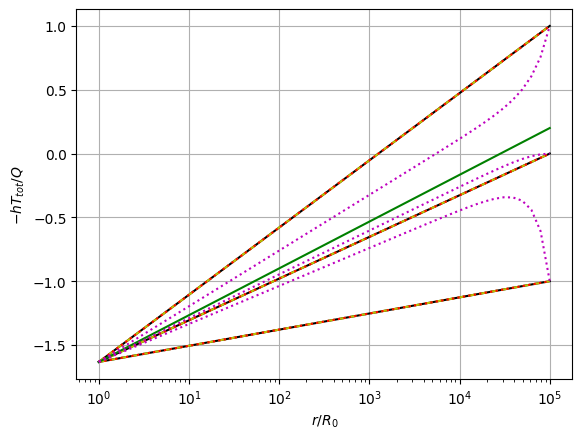

In [37]:
# analytical solution
r = np.logspace(0, 5)  # r/R0
rw = 1  # R0/R0
R = r[-1]  # R1/R0
T = np.array([0.1, 0.6, 0.3])  # T/Ttot
Q = -1  # pumping: Q < 0
h0 = [-1, 0, 1]  # -h0*Ttot/Q
h = sokol(r, rw, R, T, Q, h0, axi=True)  # -h*Ttot/Q

# generalized semi-analytical solution
nlay = len(T)
phi = np.zeros((nlay + 2, 1))
phi[1:-1, 0] = h0
c = np.inf * np.ones((nlay + 1, 1))
c[1:-1, 0] = 1e20  # c is sensitive, but inf gives NaN!
m = Steady(R=[rw, R], T=T[:, np.newaxis], c=c, Q=[Q], iwell=np.ones(nlay), h0=phi, axi=True)

# finite-difference solution
num = Steady2Numerical(m, dr=1e-7)
num.solve()

plt.semilogx(r, h.T, 'k-');
plt.semilogx(r, m.h(r).T, 'y--')
plt.semilogx(num.r, num.h.T, 'r:');

# zero resistance solution
H = sokol(rw, rw, R, T, Q, h0)[0]
plt.semilogx(r, H + Q / 2 / np.pi / T.sum() * np.log(rw / r), 'g-')  # exact

# 0 < resistance < inf
c[1:-1, 0] = 1e10  # ctot*Ttot/R0**2
m = Steady(R=[rw, R], T=T[:, np.newaxis], c=c, Q=[Q], iwell=np.ones(nlay), h0=phi, axi=True)
plt.semilogx(r, m.h(r).T, 'm:')

plt.xlabel('$r/R_0$')
plt.ylabel('$-hT_{tot}/Q$')
plt.grid();

### Transient flow to a multi-aquifer well

Dimensionless parameter example (Section 6.5.2, Figure 4):

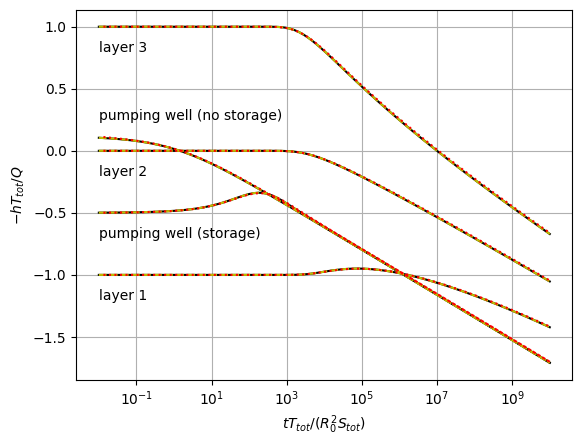

In [38]:
# analytical solution
rw = 1  # R0
rc = 10  # rc/R0/sqrt(Stot)
r = 100  # r/R0
hwell = -0.5  # -H*Ttot/Q
T = np.array([0.1, 0.6, 0.3])  # T/Ttot
S = np.array([0.25, 0.5, 0.25])  # S/Stot
Q = -1  # pumping: Q < 0
h0 = [-1, 0, 1]  # -h0*Ttot/Q
t = np.logspace(-2, 10, 100)  # t*Ttot/Stot/R0**2
# no wellbore storage
h = wikramaratna(r=[rw, r], t=t, rw=rw, T=T, S=S, Q=Q, h0=h0, axi=True, ns=10)  # -h*Ttot/Q
h = h.reshape((6, -1))[[0, 1, 3, 5]].T
plt.semilogx(t, h, 'k-');
# wellbore storage
hrc = wikramaratna(r=[rw], t=t, rw=rw, T=T, S=S, Q=Q, h0=h0, rc=rc, hwell=hwell, axi=True, ns=10)  # -h*Ttot/Q
hrc = hrc[0, 0, :]
plt.semilogx(t, hrc, 'k-');

# generalized semi-analytical solution
nlay = len(T)
phi = np.zeros((nlay + 2, 1))
phi[1:-1, 0] = h0
c = np.inf * np.ones((nlay + 1, 1))
m = Transient(R=[rw, np.inf], T=T[:, np.newaxis], S=S[:, np.newaxis], c=c, Q=[Q],
              iwell=np.ones(nlay), h0=phi, axi=True, rc=[0.0])
plt.semilogx(t, m.h(r=[rw, r], t=t).reshape((6, -1))[[0, 1, 3, 5]].T, 'y--');
mrc = Transient(R=[rw, np.inf], T=T[:, np.newaxis], S=S[:, np.newaxis], c=c, Q=[Q],
                iwell=np.ones(nlay), h0=phi, axi=True, rc=[rc], H0=[hwell])
plt.semilogx(t, mrc.h(r=[rw], t=t)[0, 0, :], 'y--');

# finite-difference solution
T4num = np.tile(T[:, np.newaxis], (1, 2))
S4num = np.tile(S[:, np.newaxis], (1, 2))
c4num = np.tile(c, (1, 2))
phi4num = np.tile(phi, (1, 2))
m4num = Transient(R=[rw, r, np.inf], T=T4num, S=S4num, c=c4num, Q=[Q],
                  iwell=np.ones(nlay), h0=phi4num, axi=True, rc=[0.0])
mrc4num = Transient(R=[rw, r, np.inf], T=T4num, S=S4num, c=c4num, Q=[Q],
                    iwell=np.ones(nlay), h0=phi4num, axi=True, rc=[rc], H0=[hwell])
num = Transient2Numerical(m4num, t=t, dr=1e-5)
num.solve()
i = np.argmin(np.abs(num.r - r))
plt.semilogx(num.t[1:], num.h[:, [0, i], 1:].reshape(6, -1)[[0, 1, 3, 5]].T, 'r:');
numrc = Transient2Numerical(mrc4num, t=t, dr=1e-5)
numrc.solve()
plt.semilogx(numrc.t[1:], numrc.h[0, 0, 1:], 'r:');

plt.xlabel('$tT_{tot} / (R_0^2S_{tot})$');
plt.ylabel('$-hT_{tot}/Q$');
plt.text(1E-2, -1.2, 'layer 1');
plt.text(1E-2, -0.2, 'layer 2');
plt.text(1E-2, 0.8, 'layer 3');
plt.text(1E-2, 0.25, 'pumping well (no storage)');
plt.text(1E-2, -0.7, 'pumping well (storage)');
plt.grid();

### The UWD solution

Dimensionless parameter example (Section 6.5.3, Figure 5):

[0.09950331 0.59701985 0.29850993]


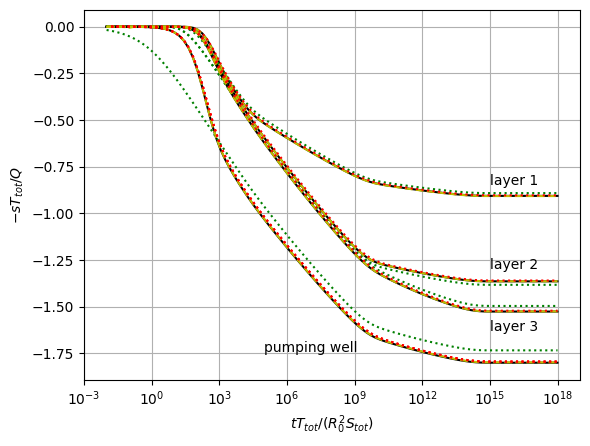

In [39]:
rw = 1  # R0/R0
rs = 1.01  # Rskin/R0  (skin)
Ts = 0.01  # Tskin/Ttot  (skin)
rc = 10  # rc/R0/sqrt(Stot)
r = 10  # r/R0
T = np.array([0.1, 0.6, 0.3])  # T/Ttot
S = np.array([0.25, 0.5, 0.25])  # S/Stot
c = np.array([1e5, 1e10, 1e15, np.inf])  # c*Ttot/R0**2
Q = -1  # pumping: Q < 0
t = np.logspace(-2, 18, 100)  # t*Ttot/Stot/R0**2
hemker = Hemker(T=T, S=S, c=c, r_in=rw, Q=[Q, 0, 0], well=np.ones(len(T)), rc=[rc],
                F=T / Ts * np.log(rs / rw))
print(hemker.F)  # dimensionless skin factor
plt.semilogx(t, hemker.hw(t)[0, :], 'k-');  # -sw*Ttot/Q (pumping well)
plt.semilogx(t, hemker.h(r=[r], t=t).squeeze().T, 'k-');  # -h*Ttot/Q (observation well)

noskin = Hemker(T=T, S=S, c=c, r_in=rw, Q=[Q, 0, 0], well=np.ones(len(T)), rc=[0])
plt.semilogx(t, noskin.hw(t)[0, :], 'g:');
plt.semilogx(t, noskin.h(r=[r], t=t).squeeze().T, 'g:');

nlay = len(T)
T4m = np.hstack(( np.ones((nlay, 1)) * Ts, T[:, np.newaxis]))
S4m = np.tile(S[:, np.newaxis], (1, 2))
c4m = np.tile(c[:, np.newaxis], (1, 2))
m = Transient(R=[rw, rs, np.inf], T=T4m, S=S4m, c=c4m, Q=[Q],
              iwell=np.ones(nlay), axi=True, rc=[rc], ns=6)
plt.semilogx(t, m.h(r=[rw, r], t=t).reshape((6, -1))[[0, 1, 3, 5]].T, 'y--');

T4num = np.hstack((T4m, T[:, np.newaxis]))
S4num = np.hstack((S4m, S[:, np.newaxis]))
c4num = np.hstack((c4m, c[:, np.newaxis]))
m2num = Transient(R=[rw, rs, r, np.inf], T=T4num, S=S4num, c=c4num, Q=[Q],
                  iwell=np.ones(nlay), axi=True, rc=[rc], ns=8)
num = Transient2Numerical(m2num, t=t, dr=1e-5, R_inf=1e10)
num.solve()
i = np.argmin(np.abs(num.r - r))
plt.semilogx(num.t[1:], num.h[1:, 0, 1:].T, 'r:');
plt.semilogx(num.t[1:], num.h[1:, i, 1:].T, 'r:');

plt.xlabel('$tT_{tot} / (R_0^2S_{tot})$')
plt.ylabel('$-sT_{tot}/Q$')
plt.text(1E15, -0.85, 'layer 1');
plt.text(1E15, -1.3, 'layer 2');
plt.text(1E15, -1.63, 'layer 3');
plt.text(1E5, -1.74, 'pumping well');
plt.grid();

### The KGS model

Dimensionless parameter example (Section 6.5.4, Figure 6):

In [110]:
# input parameters

confined = False  # watertable aquifer
b = 1  # screen length
B = 10  # aquifer thickness
d = 2  # distance between top of screen and water table
rw = 0.01  # radius of well-screen
rc = 0.1  # radius of well-casing
rs = 0.05  # radius of skin
Kr = 1  # horizontal conductivity of aquifer
Kz = 1e-1  # vertical conductivity of aquifer
Ss = 1e-8/2  # specific storage of aquifer
Sss = Ss  # specific storage of skin
H0 = 1  # initial and instantaneous head change in the well
t = np.logspace(-6, 2, 100)  # simulation times
tD = t*b*Kr/rc**2  # dimensionless time t*b*Kh/rc²
print(f'alpha = {2*rw**2*Ss*b/rc**2}')

alpha = 9.999999999999998e-11


100.0
1.0
0.01


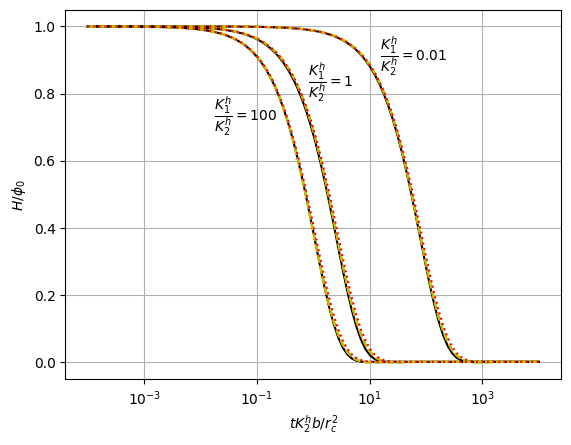

In [111]:
# creating the plot

pos = [(1.5E1, 0.9), (0.8, 0.82), (1.7E-2, 0.72)]  # position of text labels
for xy, Krs in zip(pos, [0.01, 1, 100]):  # Krs = horizontal conductivity of skin

    Kzs = Krs  # vertical conductivity of skin
    print(Kr/Krs)

    # KGS solution
    H, _ ,_ = kgs(t, H0,  # time, initial head change in well
                  rw, rc, rs, # radius of well screen, casing, skin
                  B, b, d, confined,  # aquifer thickness, screen length, distance top screen top aquifer
                  Kr, Kz, Ss,  # aquifer
                  Krs, Kzs, Sss,  # skin
                  ns=10, maxerr=1e-6, miniter=10, maxiter=500, htol=1e-5)
    plt.semilogx(tD, H, 'k-');
    plt.text(*xy, '$\dfrac{K^h_1}{K^h_2}='+str(Krs)+'$');

    # generalized semi-analytical solution
    nl = 30
    D = B / nl
    T = Kr * D * np.ones((nl, 2))
    T[:, 0] = Krs * D
    S = Ss * D * np.ones((nl, 2))
    S[:, 0] = Sss * D
    c = np.inf * np.ones((nl + 1, 2))
    c[:-1, 0] = D / Kzs
    c[:-1, 1] = D / Kz
    c[0, :] /= 2
    iwell = np.zeros(nl)
    z = np.arange(nl) * D
    iwell[(z >= d) & (z < d + b)] = 1
    m = Transient(R=[rw, rs, np.inf], T=T, S=S, c=c, iwell=iwell, H0=[H0], rc=[rc], ns=6)
    i = np.where(iwell==1)[0]
    plt.semilogx(tD, m.h([rw], t)[i, 0, :].T, 'y--');

    # finite-difference solution
    num = Transient2Numerical(m, t=t)
    num.solve()
    plt.semilogx(num.t*b*Kr/rc**2, num.h[i+1, 0, :][0, :], 'r:');

plt.grid();
plt.xlabel("$tK^h_2b/r_c^2$");
plt.ylabel("$H/\phi_0$");

### A multilayer well surrounded by multiple zones

Dimensionless parameter example (Section 6.5.5, Figure 8):

In [51]:
# input parameters
R = [0.15, 0.16, 0.25, 0.26, 2, 100, np.inf]  # distances (m) of zone boundaries
nz = len(R) - 1  # number of zones
D = np.array([0.01, 2.5, 2.5, 1, 1, 5, 5, 5, 5, 5])  # layer thicknesses (m)
nl = len(D)  # number of layers
Kh = np.array([5, 5, 1, 0.5, 0.5, 2, 2, 5, 10, 10])  # layer horizontal conductivities (m/d)
T = np.tile((Kh * D)[:, np.newaxis], (1, nz))  # layer transmissivities (m²/d)
Ss = np.array([0.15 / D[0], 5e-3, 5e-3, 1e-4, 1e-4, 1e-3, 1e-3, 5e-4, 5e-4, 5e-4])  # layer specific storages (1/m)
S = np.tile((Ss * D)[:, np.newaxis], (1, nz))  # layer storativities (-)
Kv = np.array([1, 1, 0.1, 0.025, 0.025, 0.2, 0.2, 1, 3, 3])  # layer vertical conductivities (m/d)
caq = D / Kv / 2
caq = caq[:-1] + caq[1:]  # vertical resistances (d) between layers
c = np.inf * np.ones((nl + 1, nz))
c[1:-1, :] = caq[:, np.newaxis]
c[0, -1] = 1000  # drainage resistance (d)
N = np.zeros((nl, nz))
N[0, :-1] = 250 / 1000 / 365.25  # recharge flux (m/d)
rc = R[0]  # radius of the well-casing (m)
iwell = np.zeros(nl)
iwell[-3:] = 1  # position of the pumping well
Q = -500  # pumping rate (m³/d)
t = np.logspace(-6, 4, 100)  # simulation times (d)

In [52]:
# simulations without wellbore storage and without skin

# semi-analytical solution
m = Transient(R=R, T=T, S=S, c=c, Q=[Q], iwell=iwell, rc=[0], H=None, N=N, h0=None, axi=True, ns=8);
h_no = np.reshape(m.h(r=[R[0], R[4]], t=t)[[1, -2], :, :], (4, 100)).T

# finite-difference solution
num = Transient2Numerical(m, t=t, n=20)
num.solve()
i = np.argmin(np.abs(num.r - R[4]))
hnum_no = num.h[[2, -2, -2], [i, 0, i], :].T

In [53]:
# simulations with wellbore storage and skin

# modifying the input parameters
Kh = np.tile(Kh[:, np.newaxis], (1, nz))
Kv = np.tile(Kv[:, np.newaxis], (1, nz))
Ss = np.tile(Ss[:, np.newaxis], (1, nz))
# clay stop
Kh[-5:-3, 0:2] = 1e-5
Kv[-5:-3, 0:2] = 1e-5
Ss[-5:-3, 0:2] = 1e-5
# well-skin
Kh[-3:, 0] = 0.1
Kv[-3:, 0] = 0.1
Ss[-3:, 0] = 1e-5
# gravel pack
Kh[-3:, 1] = 50
Kv[-3:, 1] = 50
Ss[-3:, 1] = 0.1
# gravel pack skin
Kh[-3:, 2] = 1
Kv[-3:, 2] = 1
Ss[-3:, 2] = 1e-5
T = Kh * D[:, np.newaxis]
S = Ss * D[:, np.newaxis]
caq = D[:, np.newaxis] / Kv / 2
caq = caq[:-1, :] + caq[1:, :]
c = np.inf * np.ones((nl + 1, nz))
c[1:-1, :] = caq
c[0, -1] = 1000
N = np.zeros((nl, nz))
N[0, :-1] = 250 / 1000 / 365.25
rc = R[0]
iwell = np.zeros(nl)
iwell[-3:] = 1
Q = -500
t = np.logspace(-6, 4, 100)

# semi-analytical solution
m = Transient(R=R, T=T, S=S, c=c, Q=[Q], iwell=iwell, rc=[rc], H=None, N=N, h0=None, axi=True, ns=8);
h = np.reshape(m.h(r=[R[0], R[4]], t=t)[[1, -2], :, :], (4, 100)).T

# finite-difference solution
num = Transient2Numerical(m, t=t)
num.solve()
i = np.argmin(np.abs(num.r - R[4]))
hnum = num.h[[2, -2, -2], [i, 0, i], :].T

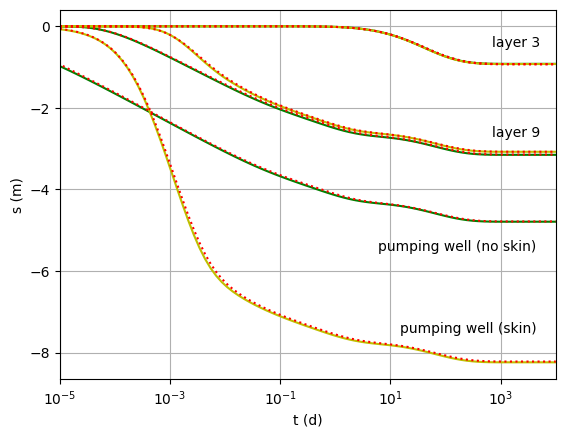

In [54]:
# creating the plot
plt.semilogx(t, h_no[:, 1:], 'g-');
plt.semilogx(t, h[:, 1:], 'y-');
plt.semilogx(num.t, hnum_no, 'r:');
plt.semilogx(num.t, hnum, 'r:');
plt.xlabel("t (d)");
plt.ylabel("s (m)");
plt.text(700, -0.5, 'layer 3');
plt.text(700, -2.7, 'layer 9');
plt.text(6, -5.5, 'pumping well (no skin)');
plt.text(15, -7.5, 'pumping well (skin)');
plt.grid();
plt.xlim((1e-5, 1e4));

### Partially penetrating well: UWG vs UWD

To show the difference between a uniform well-face gradient (UWG) and a uniform well-face drawdown (UWD) condition, the UWG solution for a partially penetrating well in a confined aquifer developed by Mishra et al. (2012) is compared with the UWD solution developed by Hemker (1999). This example is not part of my PhD thesis.

In [ ]:
# UWG simulations (Mishra et al., 2012)

# input
Kr = 10     # horizontal conductivity (m/d)
Kz = 1      # vertical conductivity (m/d)
Ss = 0.001  # specific elastic storage (1/m)
D = 10      # aquifer thickness (m)
Q = -100    # pumping rate (m³/d)
rw = 0.1    # well-screen radius (m)
L = 5       # well-screen length (m)
B = 0       # distance (m) between top of screen and top of aquifer
r = rw      # radial distance (m) of observations = well-screen face
levels = np.arange(5) + 0.5  # vertical distance (m) of observations
t = np.logspace(-5, 5, 100)  # observation times (d)

# drawdown at z, wellbore storage included
s1 = [mishra(r, z, t, Kr, Kz, Ss, D, Q, rw, L, B, wbs=True, maxn=100, eps=1e-10, ns=10) for z in levels]

# drawdown at z, wellbore storage not included
s2 = [mishra(r, z, t, Kr, Kz, Ss, D, Q, rw, L, B, wbs=False, maxn=100, eps=1e-10, ns=10) for z in levels]

# drawdown averaged over well-screen, wellbore storage included
s3 = mishra(r, [0, L], t, Kr, Kz, Ss, D, Q, rw, L, B, wbs=True, maxn=100, eps=1e-10, ns=10)

In [140]:
# UWD simulations (Hemker, 1999)

nl = 10  # number of sublayers
d = D / nl  # thickness of sublayers (m)
T = Kr * d * np.ones(nl)  # sublayer transmissivities (m²/d)
S = Ss * d * np.ones(nl)  # sublayer storativities (-)
c = np.inf * np.ones(nl + 1)
c = np.inf * np.ones(nl + 1)
c[1:-1] = d / Kz  # vertical resistance between sublayers
iwell = np.zeros(nl)
nwell = int(L / d)  # number of screened sublayers
iwell[:nwell] = 1  # position of screened sublayers
Qs = np.zeros(nl)
Qs[0] = Q

m = Hemker(T=T, S=S, c=c, r_in=rw, Q=Qs, well=iwell, rc=[rw])

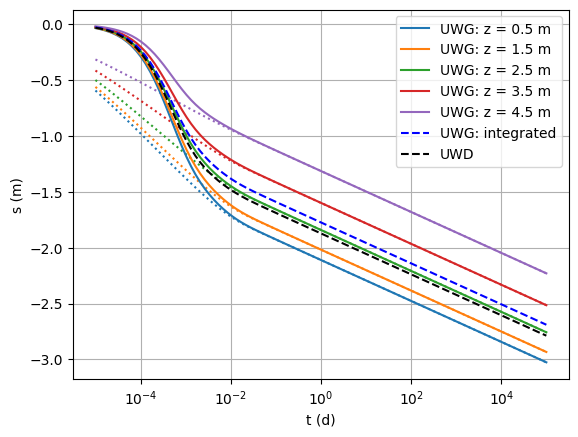

In [154]:
# plot
lines1 = plt.semilogx(t, np.array(s2).T, ':');
lines2 = plt.semilogx(t, np.array(s1).T, '-', label=['UWG: z = '+str(z)+' m' for z in levels]);
for line1, line2 in zip(lines1, lines2):
    line2.set_color(line1.get_color())
plt.semilogx(t, s3, 'b--', label='UWG: integrated');
plt.semilogx(t, m.hw(t=t)[0, :], 'k--', label='UWD');
plt.legend();
plt.grid();
plt.xlabel('t (d)');
plt.ylabel('s (m)');

## References

- Hemker, C. J. (1999). Transient well flow in vertically heterogeneous aquifers. Journal of Hydrology, 225(1–2), 1–18. https://doi.org/10.1016/S0022-1694(99)00137-7

- Hyder, Z., Butler, J. J., McElwee, C. D., & Liu, W. (1994). Slug tests in partially penetrating wells. Water Resources Research, 30(11), 2945–2957. https://doi.org/10.1029/94WR01670

- Louwyck, A. (2023). Axisymmetric Flow in Multilayer Aquifer Systems: Solutions and Theoretical Considerations. PhD thesis, Laboratory for Applied Geology and Hydrogeology, Department of Geology, Ghent University, Belgium.

- Louwyck, A., Vandenbohede, A., Bakker, M., & Lebbe, L. C. (2012). Simulation of axi-symmetric flow towards wells: A finite-difference approach. Computers & Geosciences, 44, 136–145. https://doi.org/10.1016/j.cageo.2011.09.004

- Mishra, P. K., Vesselinov, V. v., & Neuman, S. P. (2012). Radial flow to a partially penetrating well with storage in an anisotropic confined aquifer. Journal of Hydrology, 448–449, 255–259. https://doi.org/10.1016/j.jhydrol.2012.05.010

- Neville, C. J., & Tonkin, M. J. (2004). Modeling Multiaquifer Wells with MODFLOW. Ground Water, 42(6), 910–919. https://doi.org/10.1111/j.1745-6584.2004.t01-9-.x

- Papadopulos, I. S. (1966). Nonsteady flow to multiaquifer wells. Journal of Geophysical Research, 71(20), 4791–4797. https://doi.org/10.1029/JZ071i020p04791

- Sokol, D. (1963). Position and fluctuations of water level in wells perforated in more than one aquifer. Journal of Geophysical Research, 68(4), 1079–1080. https://doi.org/10.1029/JZ068i004p01079

- Stehfest, H. (1970). Algorithm 368: Numerical inversion of Laplace transforms [D5]. Communications of the ACM, 13(1), 47–49. https://doi.org/10.1145/361953.361969

- Wikramaratna, R. S. (1984). An Analytical Solution for the Effects of Abstraction From a Multiple-Layered Confined Aquifer With No Cross Flow. Water Resources Research, 20(8), 1067–1074. https://doi.org/10.1029/WR020i008p01067


---